In [1]:
import csv
import seaborn as sns
import numpy as np
import pandas as pd

import json
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf


In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [4]:
fname = '/raid/xiaoyuz1/amazon_turk/pre_qual/Batch_338104_batch_results.csv'
df = pd.read_csv(fname)

In [5]:
df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.PROMPT01',
       'Answer.canvasJsonOneStepName_1__0',
       'Answer.canvasJsonOneStepName_1__1',
       'Answer.canvasJsonOneStepName_1__2',
       'Answer.canvasJsonOneStepName_1__3',
       'Answer.canvasJsonOneStepName_1__4',
       'Answer.canvasJsonOneStepName_1__5',
       'Answer.canvasJsonOneStepName_1__6', 'Answer.feedback',
       'Answer.stepAnnotationInput_1', 'Approve', 'Reject'],
      dtype='object')

In [7]:
print(len(df))

55


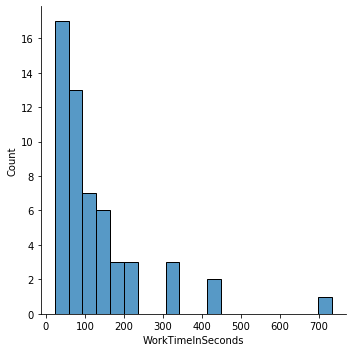

In [7]:
sns.displot(df, x="WorkTimeInSeconds", bins=20)

In [8]:
df['WorkerId'].unique().shape

(15,)

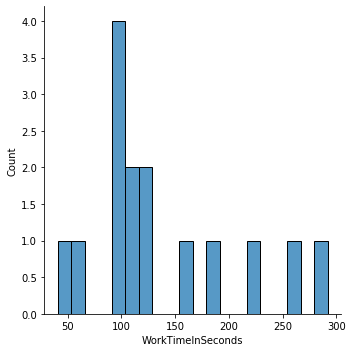

In [9]:
worker_times = []
worker_id = []
for workid in df['WorkerId'].unique():
    worker_times.append(df[df['WorkerId'] == workid]['WorkTimeInSeconds'].mean())
    worker_id.append(workid)

worker_time_dict = {'WorkerId' : worker_id, 'WorkTimeInSeconds' : worker_times}
sns.displot(pd.DataFrame.from_dict(worker_time_dict), x="WorkTimeInSeconds", bins=20)

sad face Mean:  152.63636363636363  Median:  58.0
in-love face Mean:  133.36363636363637  Median:  70.0
angry face Mean:  134.0  Median:  70.0
surprised face Mean:  108.72727272727273  Median:  99.0
nervous face Mean:  121.27272727272727  Median:  101.0


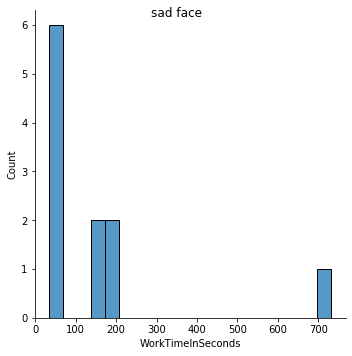

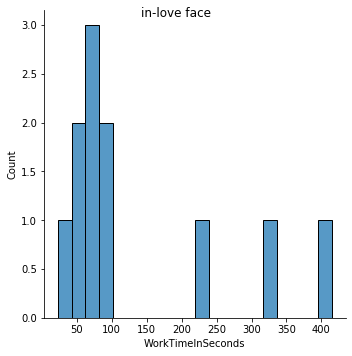

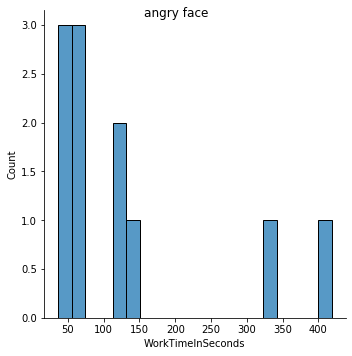

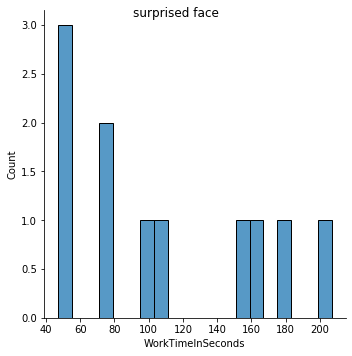

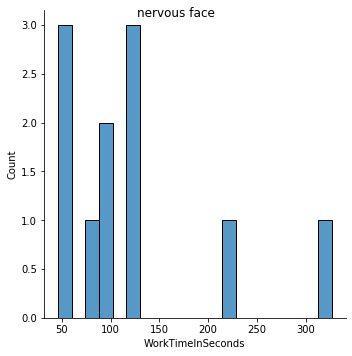

In [10]:

worker_time_by_title_dicts = []
for hitid in df['Input.PROMPT01'].unique():
    times = df[df['Input.PROMPT01'] == hitid]['WorkTimeInSeconds']
    print(hitid, "Mean: ", times.mean(), " Median: ", times.median())
    
    d = {'Input.PROMPT01' : [hitid] * times.shape[0], 'WorkTimeInSeconds' : list(times)}
    worker_time_by_title_dicts.append(pd.DataFrame.from_dict(d))
    plot = sns.displot(pd.DataFrame.from_dict(d), x="WorkTimeInSeconds", bins=20)
    plot.fig.suptitle(hitid)
    
    

       

In [11]:
# Examine the drawings 

In [8]:
def plot_canvas(df):
    hue_palette = sns.color_palette("husl", 20)

    total_num_drawings = len(df)
    print("total_num_drawings: ", total_num_drawings)
    
    
    for i in range(total_num_drawings):
        plt.figure(figsize=(10,10))
        plt.xlim(0,400)
        plt.ylim(400,0)
        
        num_parts_acc = 0
        row = df.iloc[i]
        for k,v in row.items():
            if k.startswith("Answer.canvas"):
                if v is np.nan:
                    continue
                
                part_xy, text, action_id = get_xy(v)

                for part_xy_i in part_xy:
                
                    plt.plot(part_xy_i[:,0], part_xy_i[:,1], c=hue_palette[num_parts_acc])

                    plt.annotate(
                        text, xy=(part_xy_i[:,0][0], part_xy_i[:,1][0]-20), backgroundcolor='w', fontsize=9,
                    )
                num_parts_acc += 1
        
        plt.title("idx: {}, prompt: {}".format(i,row['Input.PROMPT01']))
        plt.show()
        
#                 gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
#                 plot_gmm(gmm16, Xmoon, label=False)
    

def get_xy(answer_json):
    
    try:
        answer_dict = json.loads(answer_json)['data']
    except:
        # print("[get_xy]", answer_json)
        raise
    
    actions = answer_dict['actions']
    text = answer_dict['actionsName']
    action_id = answer_dict['id']
    
    xy = []
    for d in actions:
        if d['type'] == 0:
            xy.append([])
        xy[-1] += [[float(d['x']), float(d['y'])]]
#     for i,xyi in enumerate(xy):
#         xy[i] = np.asarray(xyi)
    return xy, text, action_id

def create_word_list(sentences):
    res = []
    for sentence in sentences:
        l = sentence.split()
        if '' in l:
            l.remove('')
        res += l
    return res


class Face:
    def __init__(self, df):
        self.df = df
        
        self.num_workers = len(df['WorkerId'].unique())
        data = {}
        
        for i in range(len(df)):
            
            df_row = df.iloc[i]
            data_i = {'WorkerId' : df_row['WorkerId']}

            strokes_texts = []
            for k,v in df_row.items():        
                if not k.startswith("Answer.canvasJsonOneStepName"):
                    continue
                if v is np.nan:
                    continue

                try:
                    part_xy, text, action_id = get_xy(v)
                    text = text.lower()

                    strokes_texts.append({
                        'annotation' : create_word_list([text.lower()]),
                        'drawing' : part_xy,
                    })
                except:
                    # print("Problem: ", i)
                    continue
            data_i['data'] = strokes_texts
            data[i] = data_i
        
        self.data = data
    
    def all_texts(self):
        texts_df = []
        for i,datai in self.data.items():
            textsi = []
            for dataij in datai['data']:
                textsi += [dataij['annotation']]
            texts_df.append(textsi)
        return texts_df
    
    def all_drawings(self):
        drawing_df = []
        for i,datai in self.data.items():
            drawingi = []
            for dataij in datai['data']:
                part_xy = dataij['drawing']
                
                if(len(part_xy) > 1):
                    part_xy = np.vstack(part_xy)
                    # part_xy = np.expand_dims(part_xy, axis=0)
                else:
                    part_xy = np.asarray(part_xy)
                    part_xy = np.squeeze(part_xy, axis=0)
                    
                drawingi += [part_xy]
            drawing_df.append(drawingi)
        return drawing_df
    
    def draw_all(self):
        hue_palette = sns.color_palette("husl", 20)
        num_plots_per_row = 10
        num_rows = np.ceil(len(self.data) / num_plots_per_row)
        plt.figure(figsize=(num_plots_per_row * 2, num_rows * 2,))
        
        plot_idx_acc = 1
        
        for row_idx in range(len(self.data)):
            datai = self.data[row_idx]['data']
            ax = plt.subplot(num_rows, num_plots_per_row , plot_idx_acc)
            plt.xlim(0,400)
            plt.ylim(400,0)
            text = None
            components_accumatlor = []
            for dataij in datai:
                text = dataij['annotation']
                part_xy = dataij['drawing']
                components_accumatlor += dataij['drawing']
            
            for part_xy_i in components_accumatlor:
                part_xy_i = np.asarray(part_xy_i)
                plt.plot(part_xy_i[:,0], part_xy_i[:,1], c=(0,0,0)) #hue_palette[plot_idx_acc]
            
            ax.title.set_text(
                "idx: {}, prompt: {}".format(row_idx, self.df.iloc[row_idx]['Input.PROMPT01']),
            )
            ax.title.set_fontsize(9)
            # plt.annotate(text, xy=(0,0), backgroundcolor='w', fontsize=9)
            plot_idx_acc += 1        
        
        plt.show()


    def draw(self, row_idx):
        datai = self.data[row_idx]['data']

        hue_palette = sns.color_palette("husl", 20)
        total_steps = len(datai)
        
        num_plots_per_row = 3
        num_rows = np.ceil(total_steps / num_plots_per_row)
        plot_idx_acc = 1
        plt.figure(figsize=(num_plots_per_row * 5, num_rows * 5,))
        
        components_accumatlor = []
        for dataij in datai:
            
            plt.subplot(num_rows, num_plots_per_row , plot_idx_acc)
            plt.xlim(0,400)
            plt.ylim(400,0)
            
            text = dataij['annotation']
            part_xy = dataij['drawing']

            components_accumatlor += part_xy
            for part_xy_i in components_accumatlor:
                part_xy_i = np.asarray(part_xy_i)
                plt.plot(part_xy_i[:,0], part_xy_i[:,1], c=(0,0,0)) #hue_palette[plot_idx_acc]

            plt.annotate(text, xy=(0,0), backgroundcolor='w', fontsize=9)
            plot_idx_acc += 1
        
        plt.title("{} {}".format(row_idx, self.df.iloc[row_idx]['Input.PROMPT01']))
        plt.show()


def create_one_drawing(df_row, row_idx, separate_steps = False):
    hue_palette = sns.color_palette("husl", 20)
    total_steps = 0
    for k,v in df_row.items():
        if k.startswith("Answer.canvasJsonOneStepName"):
            if v is np.nan:
                continue
            total_steps+=1
    
    num_plots_per_row = 3
    num_rows = np.ceil(total_steps / num_plots_per_row)
    plot_idx_acc = 1
    print(num_rows, num_plots_per_row)
    plt.figure(figsize=(num_plots_per_row * 5, num_rows * 5,))
    
    components_accumatlor = []
    
    for k,v in df_row.items():
        if not k.startswith("Answer.canvasJsonOneStepName"):
            continue
        if v is np.nan:
            continue
    
        plt.subplot(num_rows, num_plots_per_row , plot_idx_acc)
        plt.xlim(0,400)
        plt.ylim(400,0)
        # print(k, v)
        try:
            part_xy, text, action_id = get_xy(v)
        except:
            continue
        components_accumatlor += part_xy
        for part_xy_i in components_accumatlor:
            plt.plot(part_xy_i[:,0], part_xy_i[:,1], c=(0,0,0)) #hue_palette[plot_idx_acc]

        plt.annotate(text, xy=(0,0), backgroundcolor='w', fontsize=9)
        plot_idx_acc += 1

    plt.title("idx: {}, prompt: {}".format(row_idx, df_row['Input.PROMPT01']))
    plt.show()



In [9]:
face_obj = Face(df)

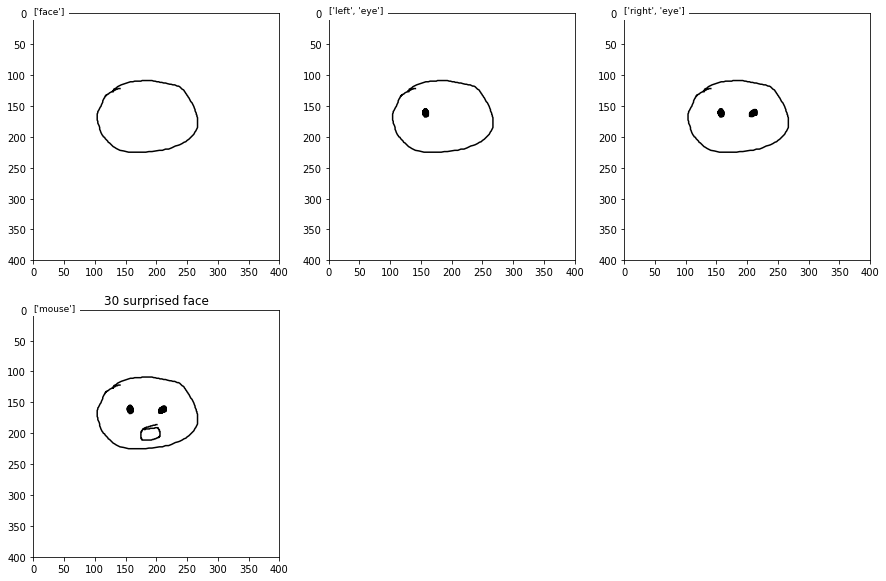

In [12]:
face_obj.draw(30)

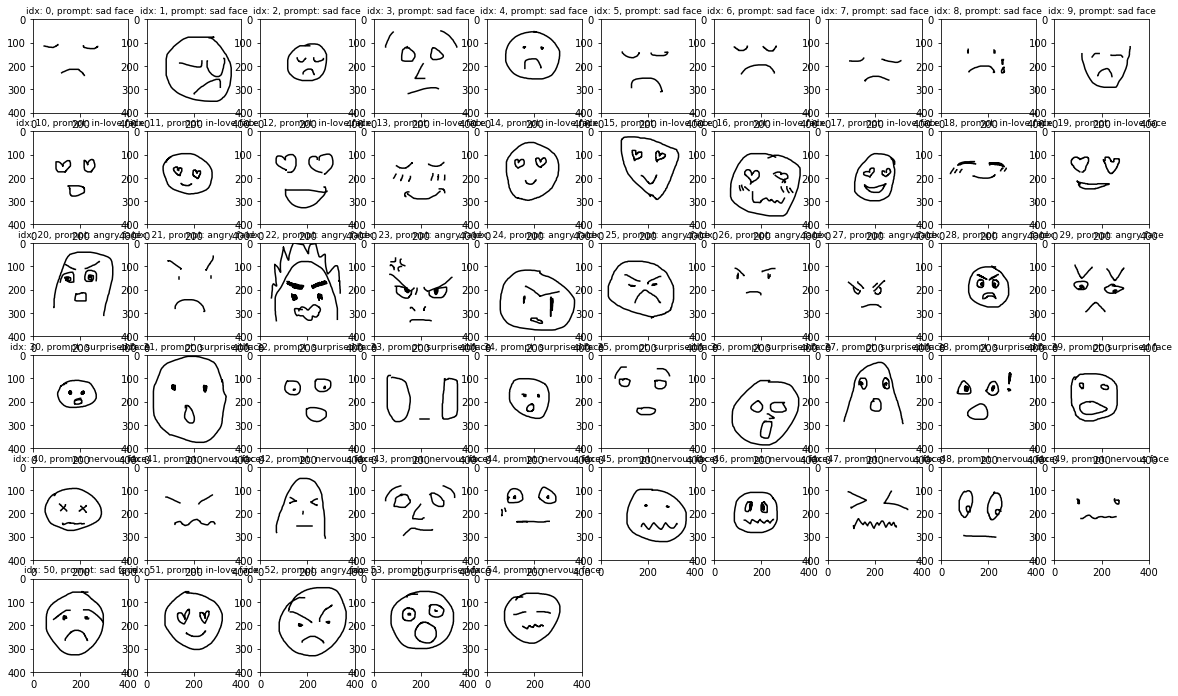

In [10]:
face_obj.draw_all()

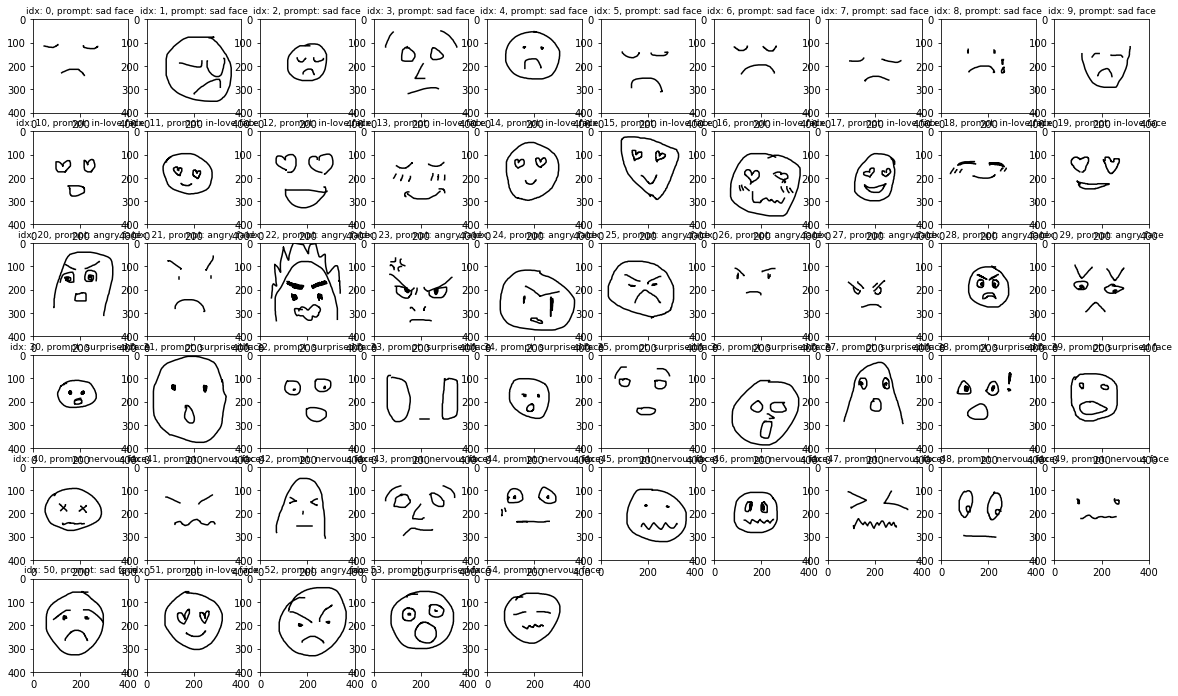

In [36]:
face_obj.draw_all()

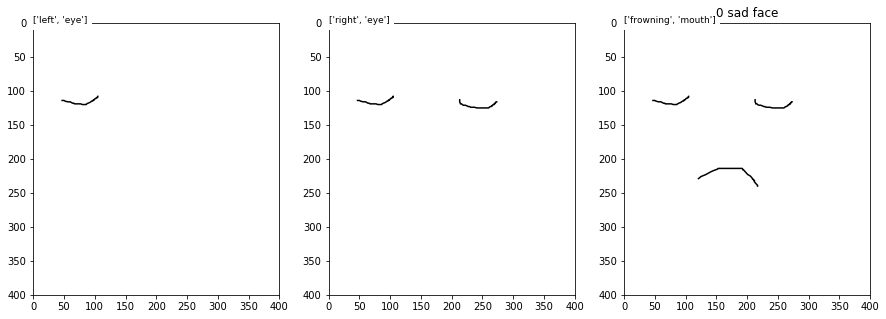

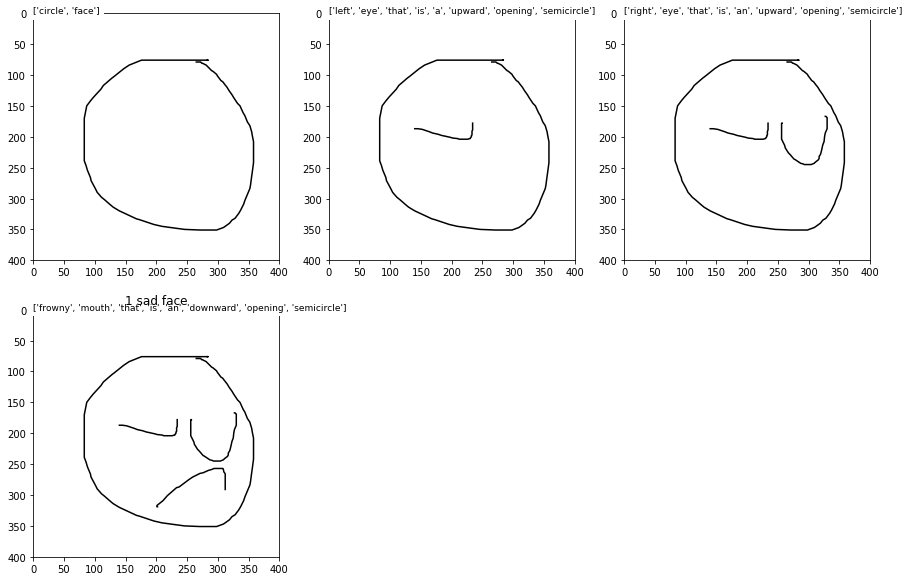

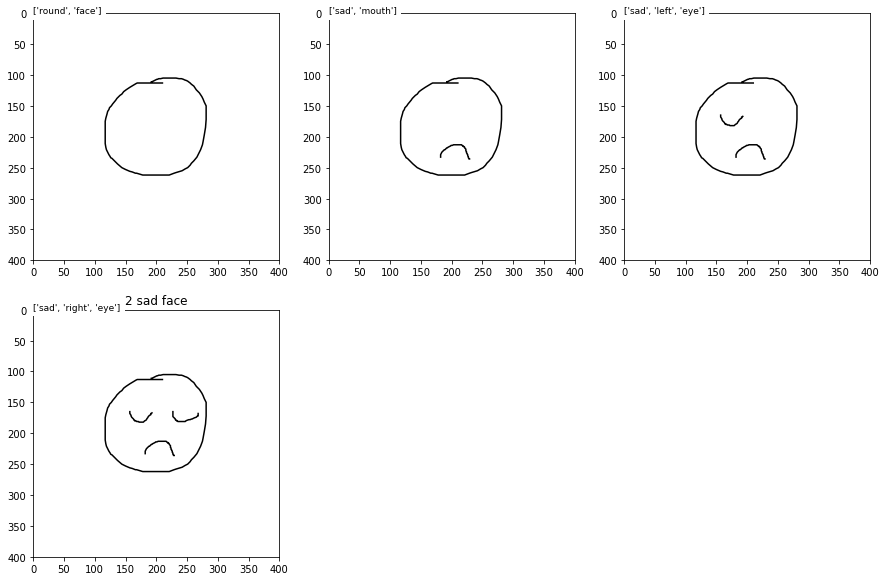

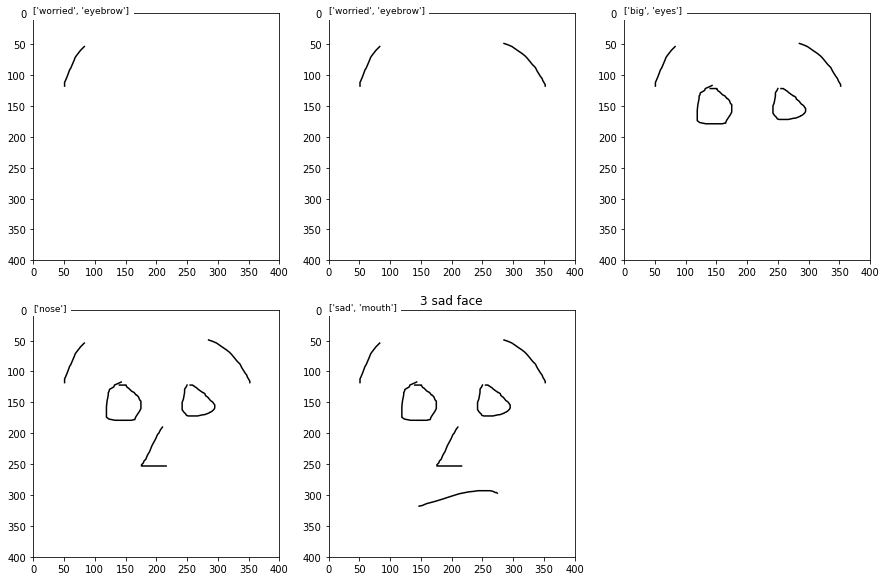

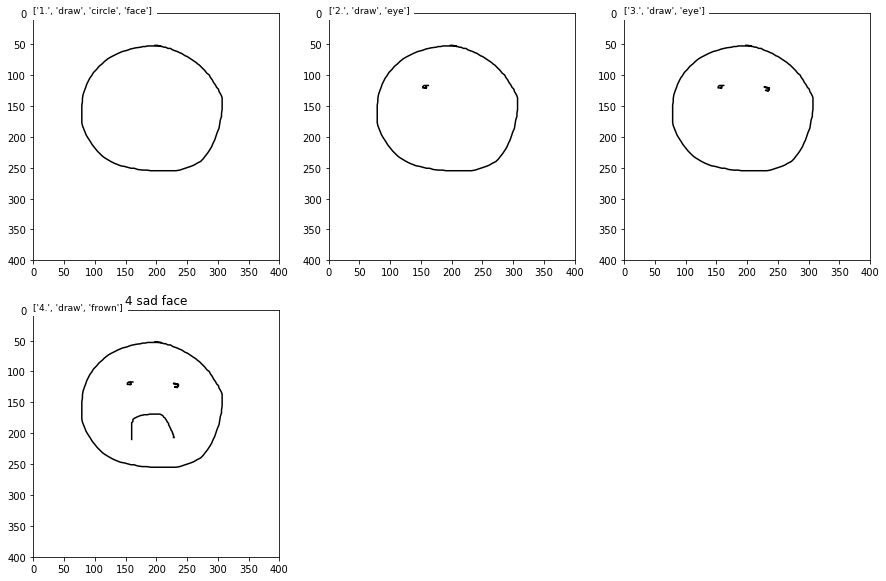

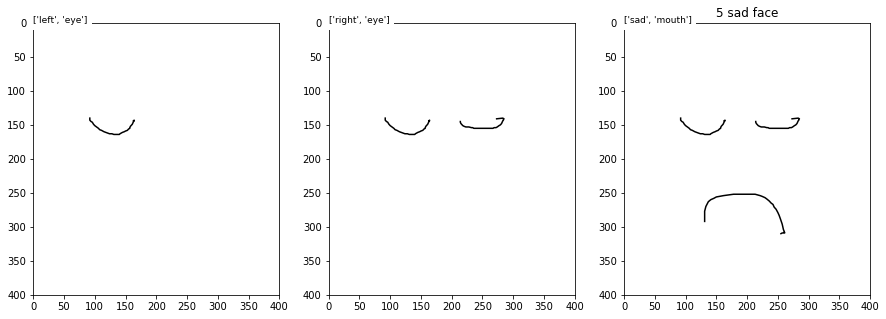

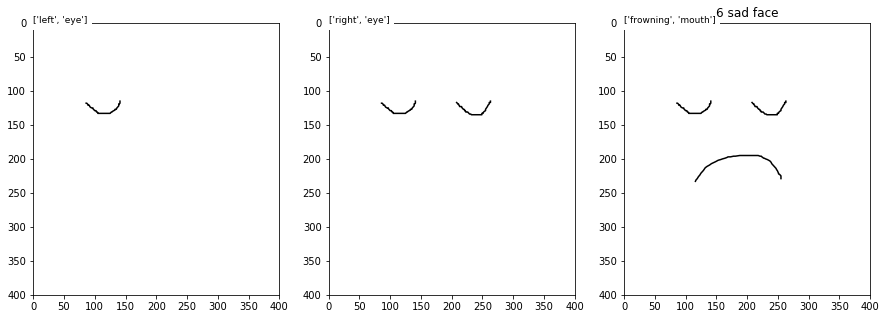

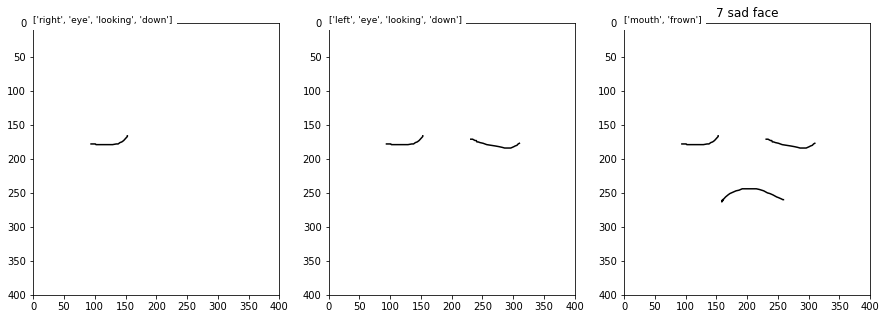

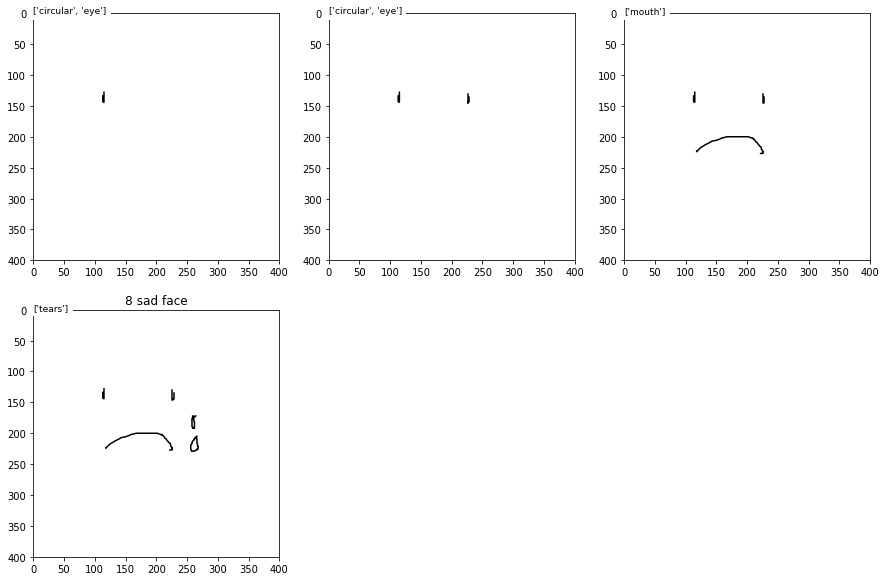

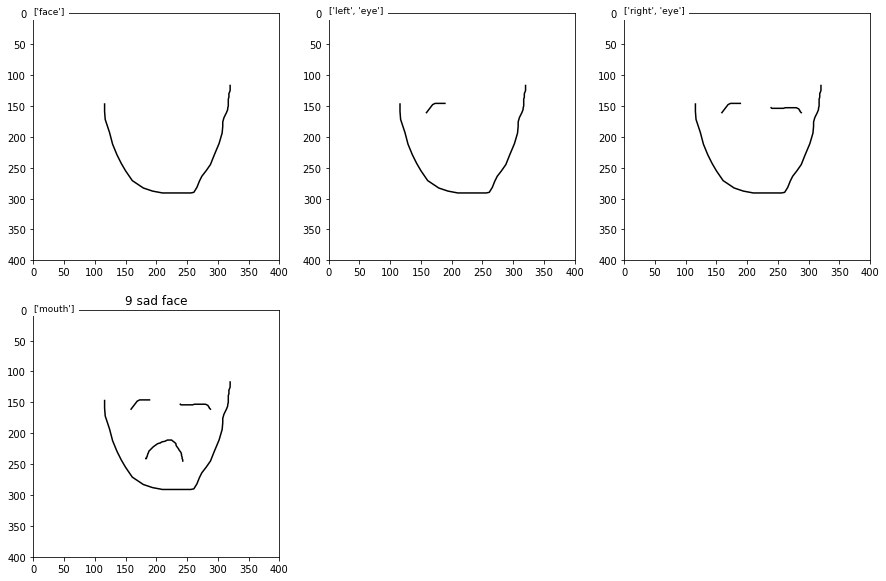

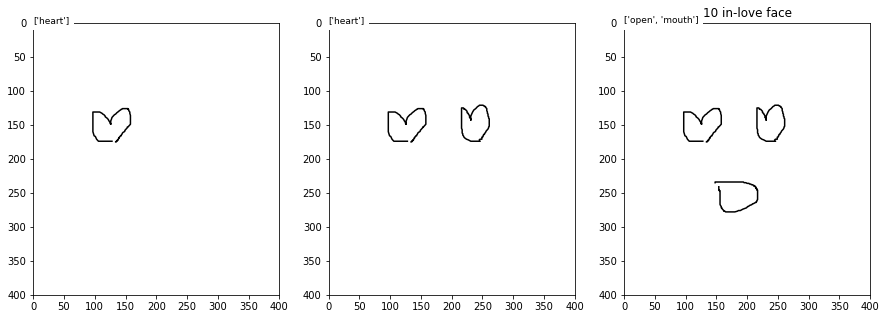

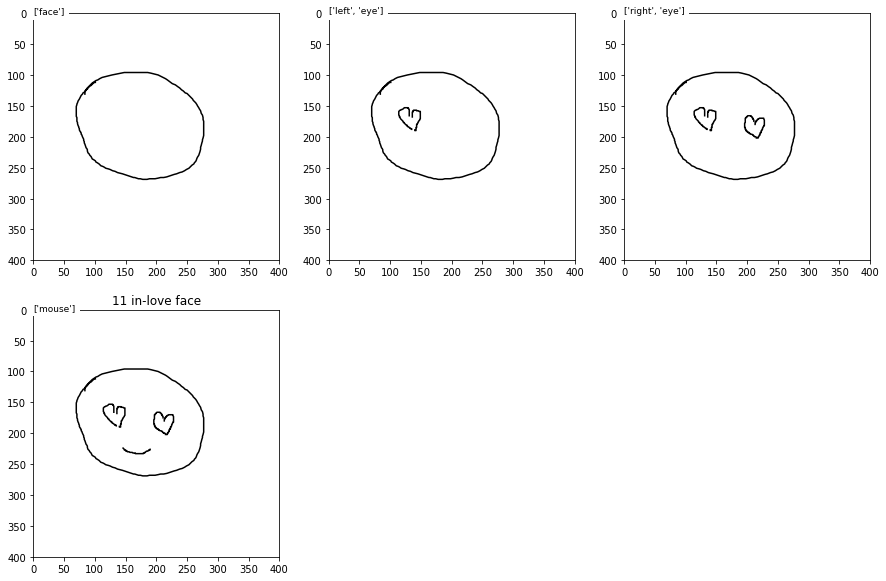

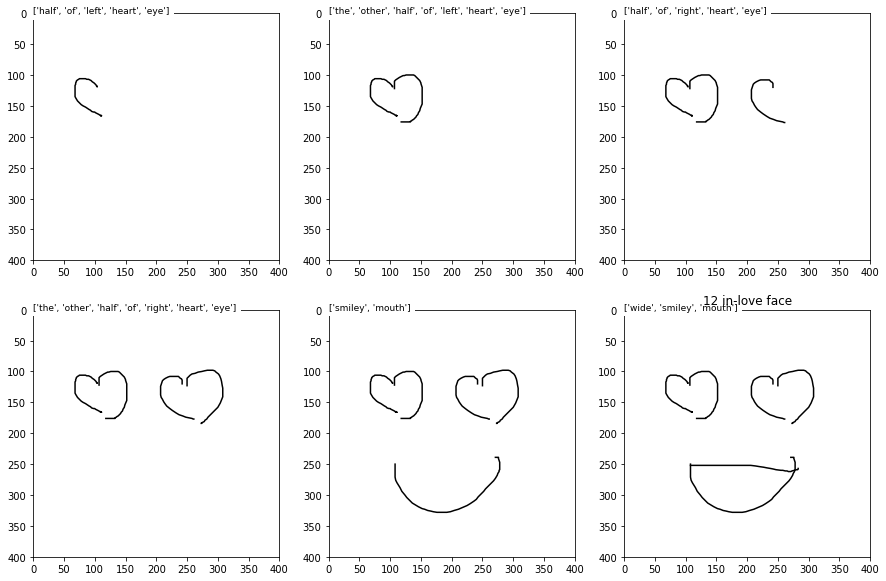

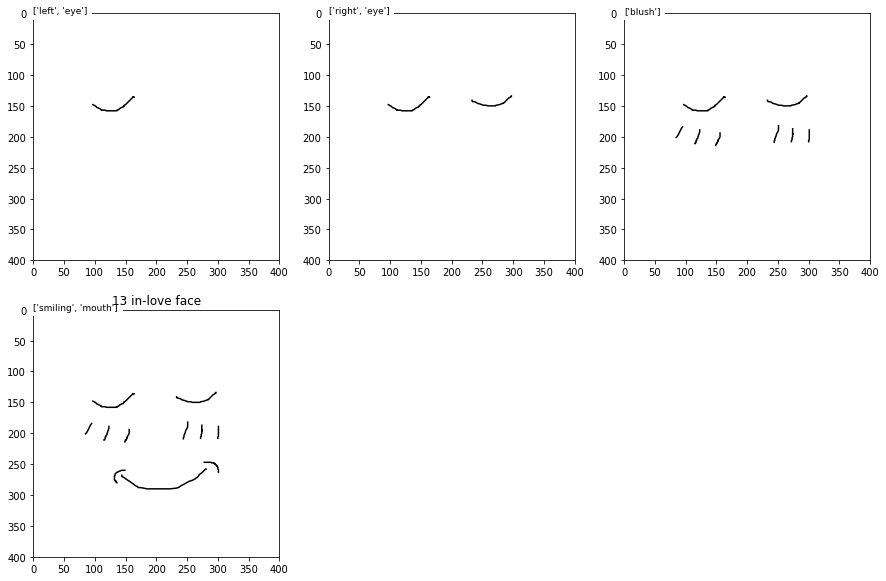

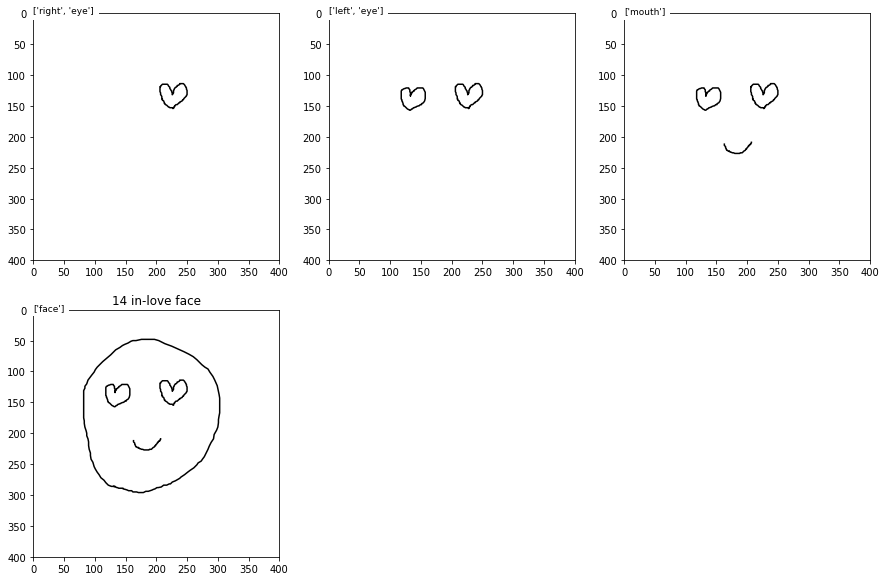

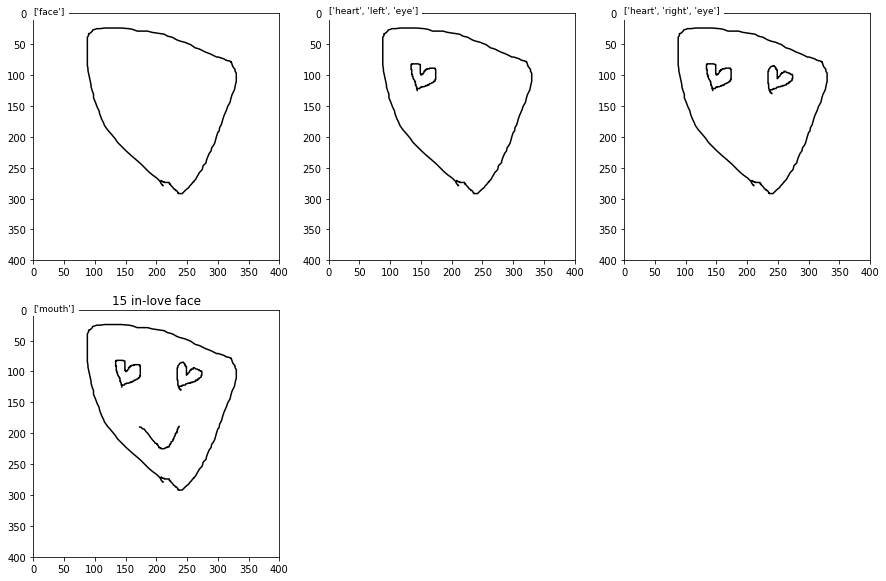

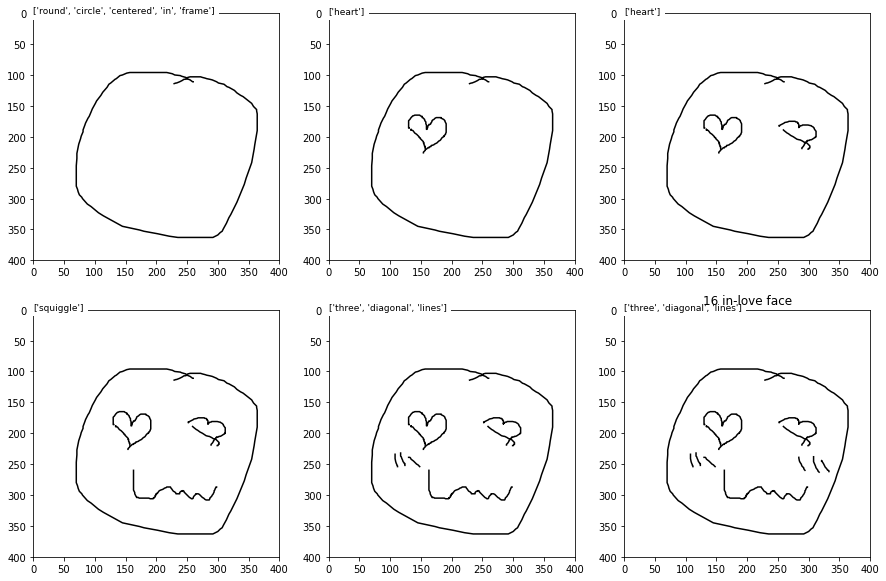

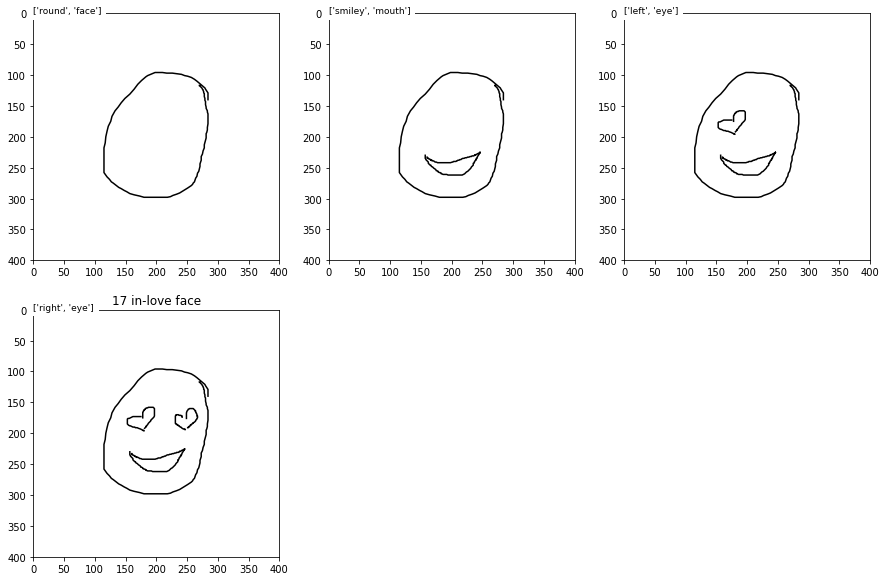

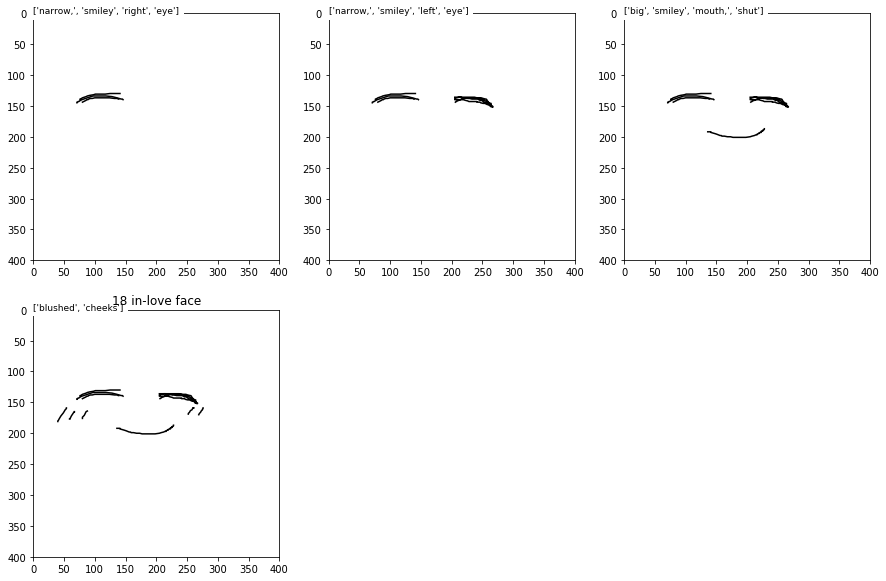

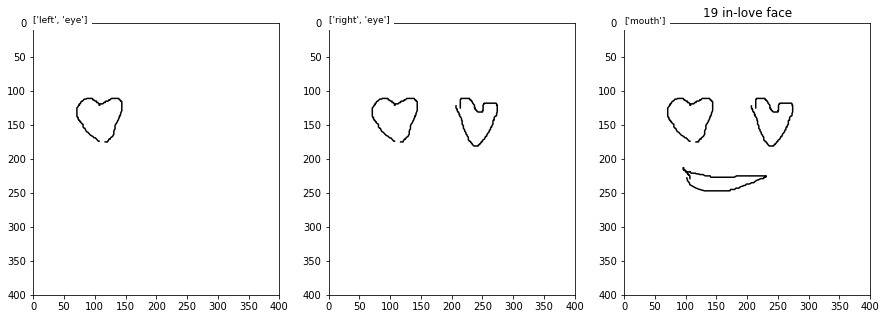

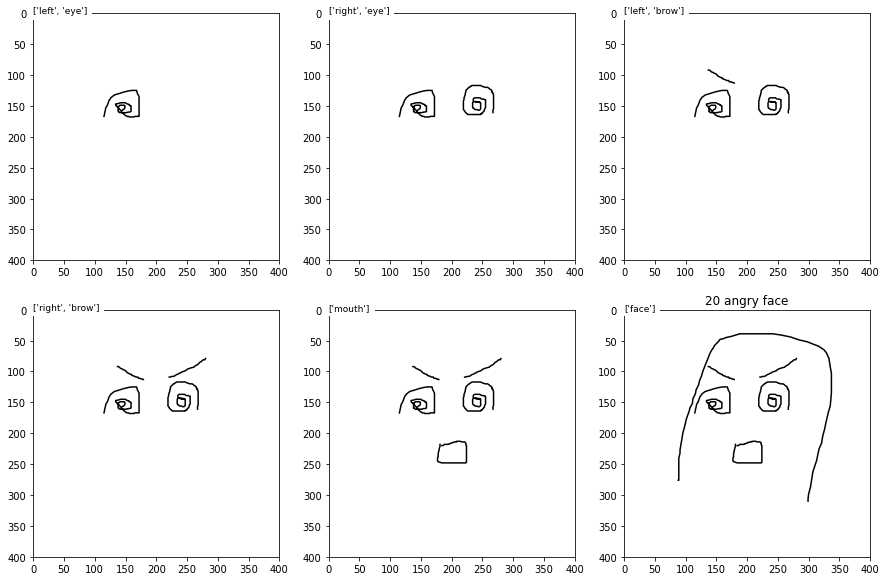

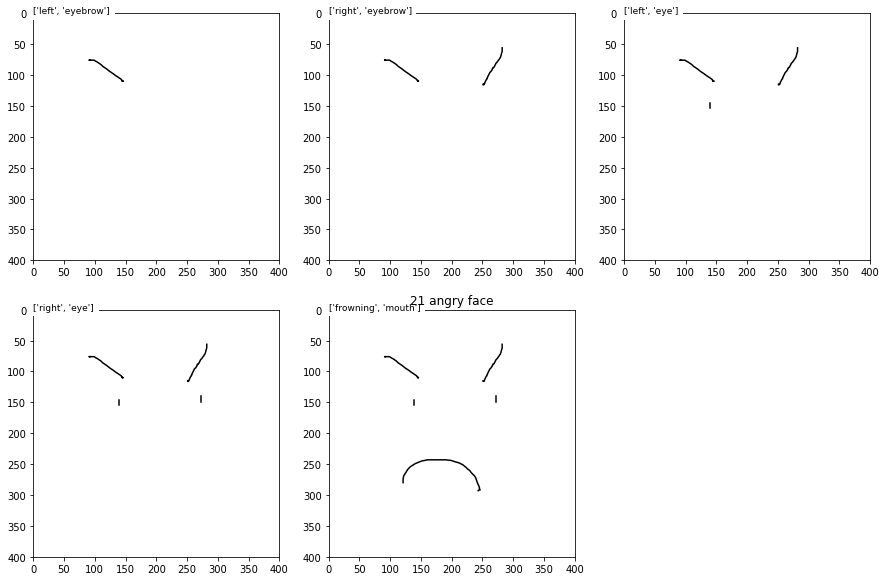

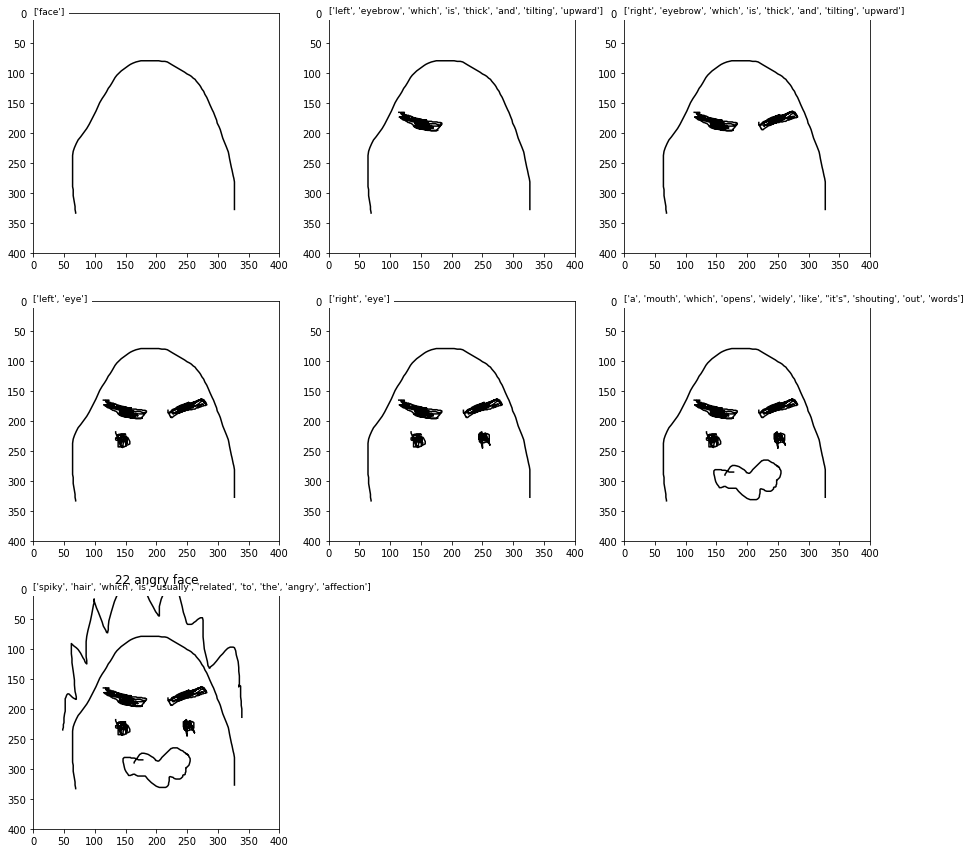

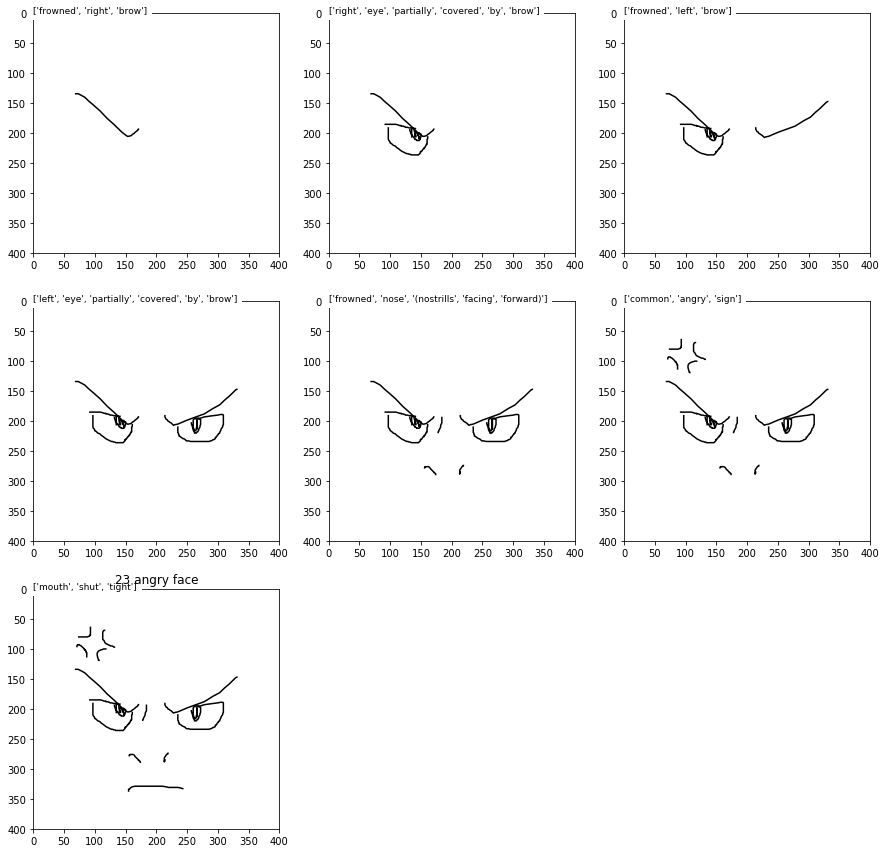

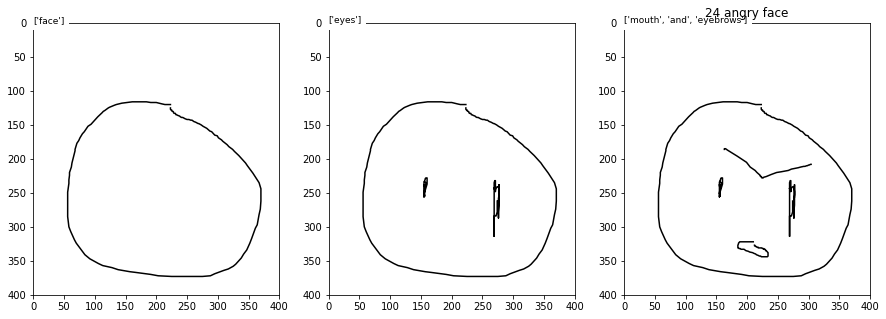

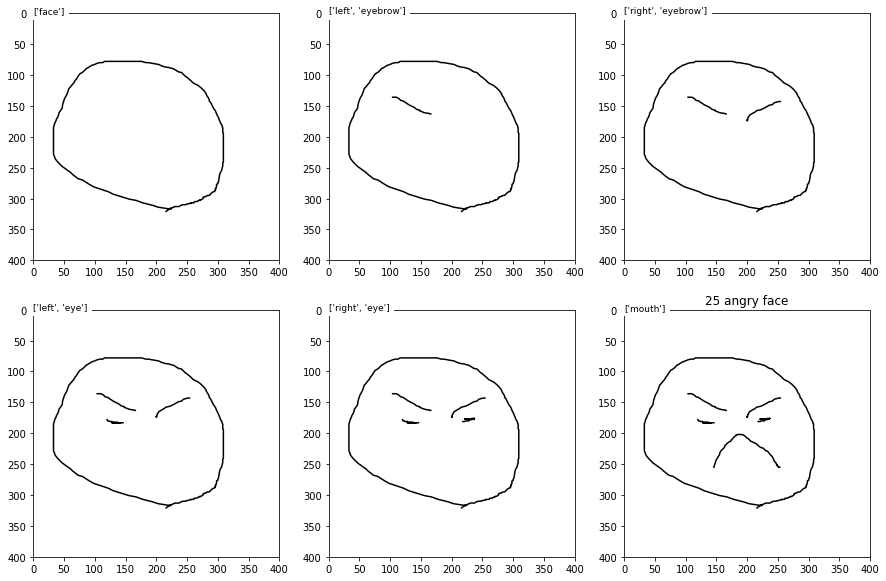

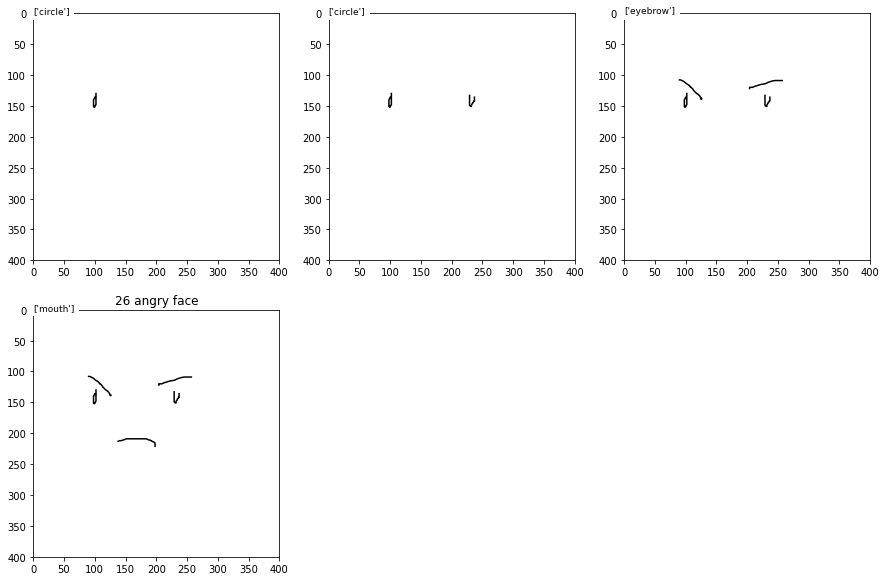

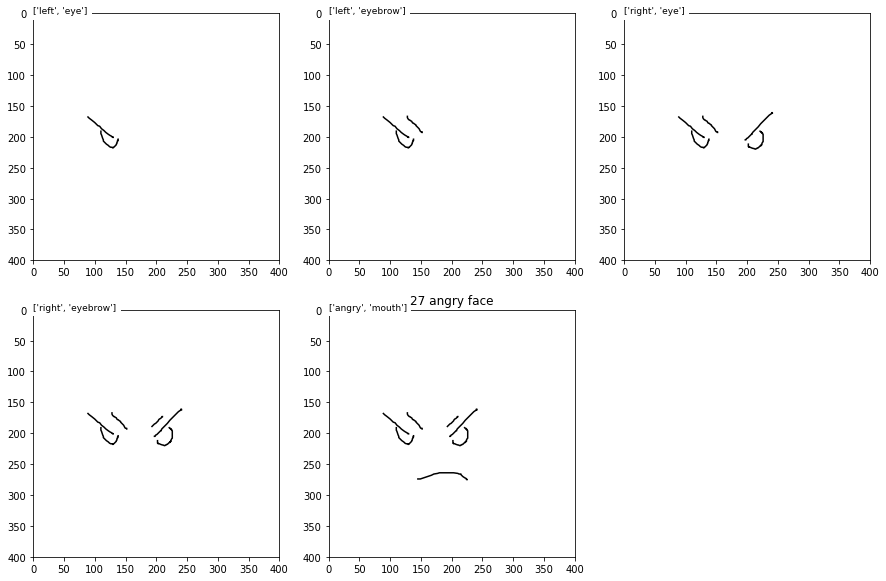

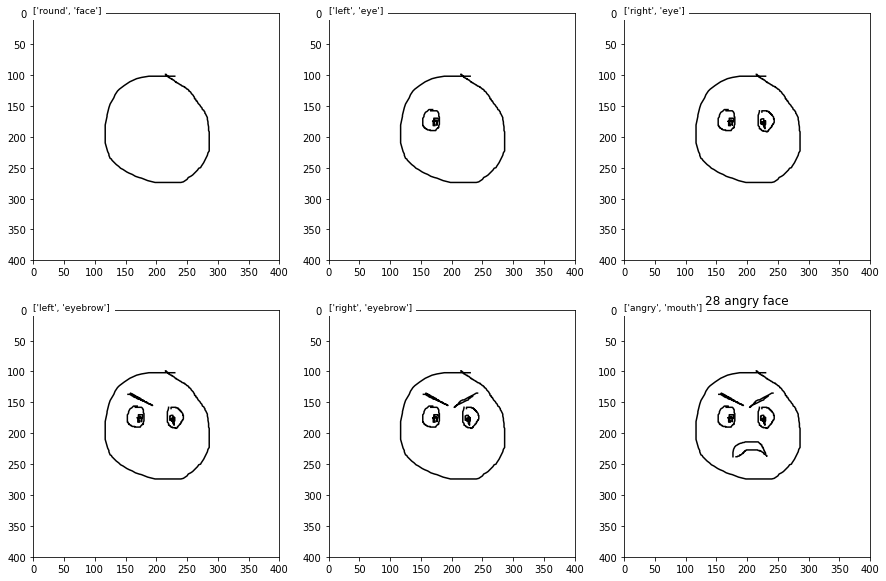

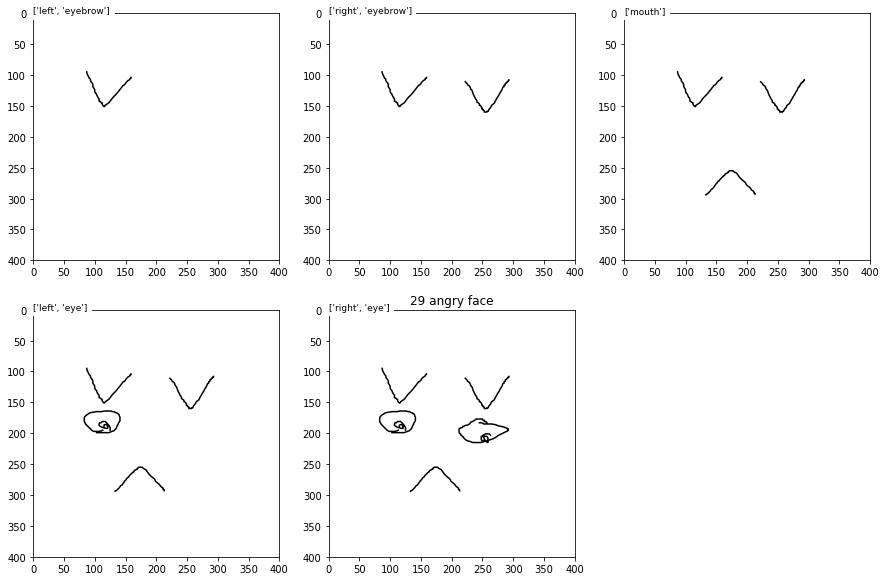

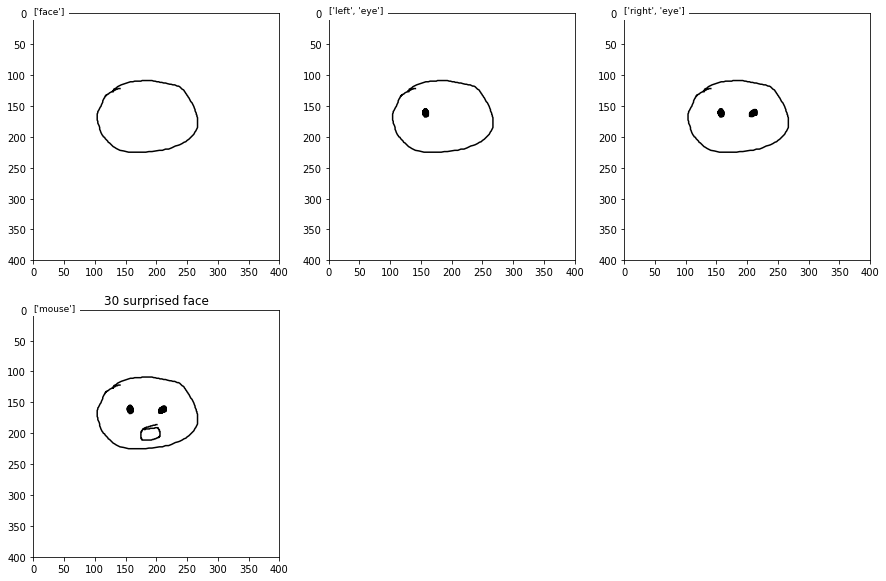

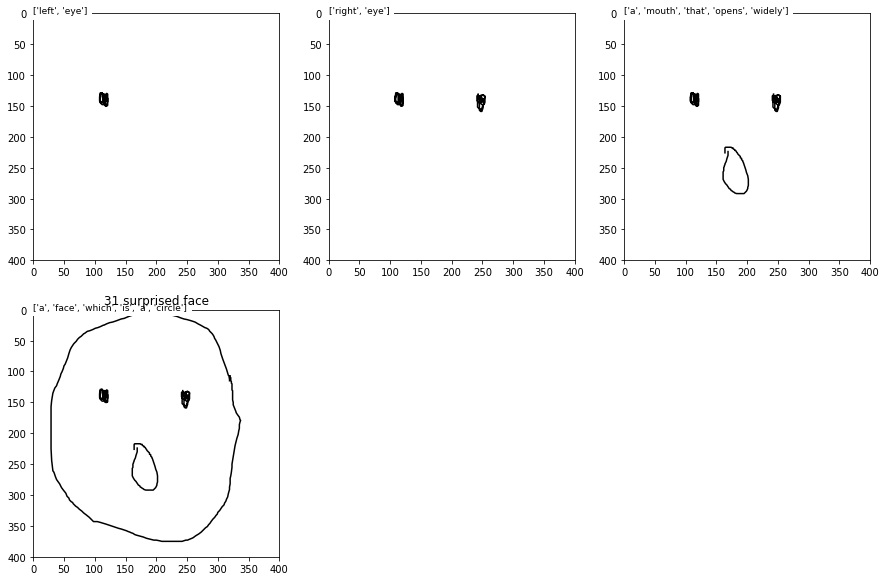

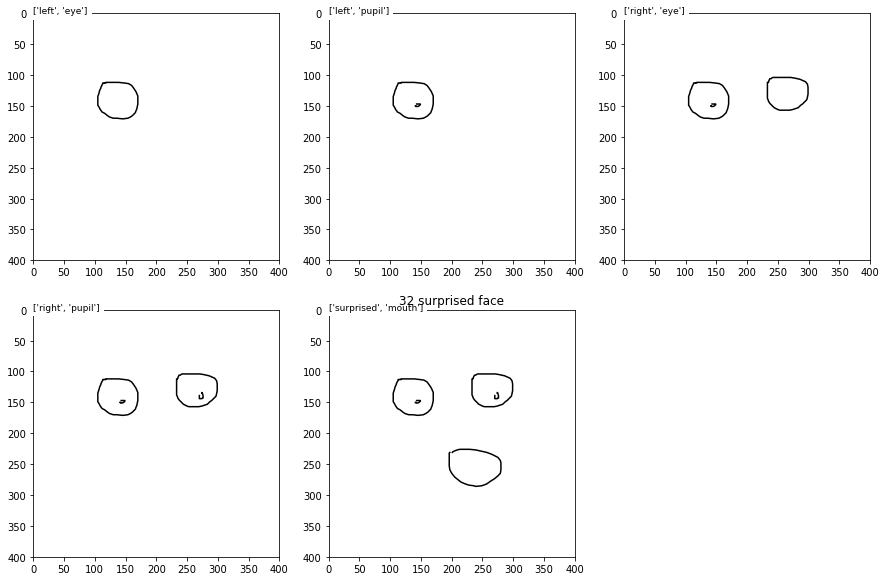

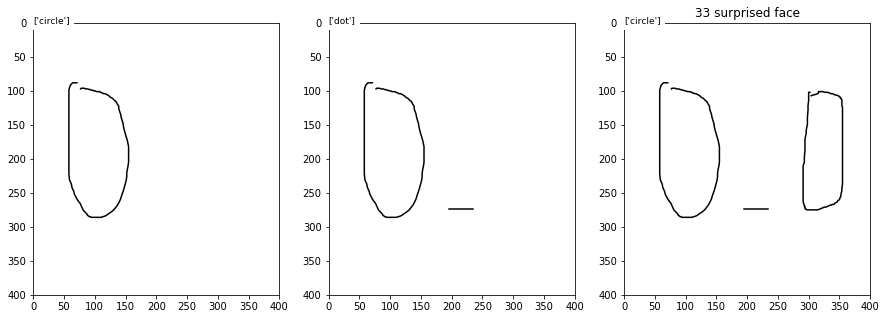

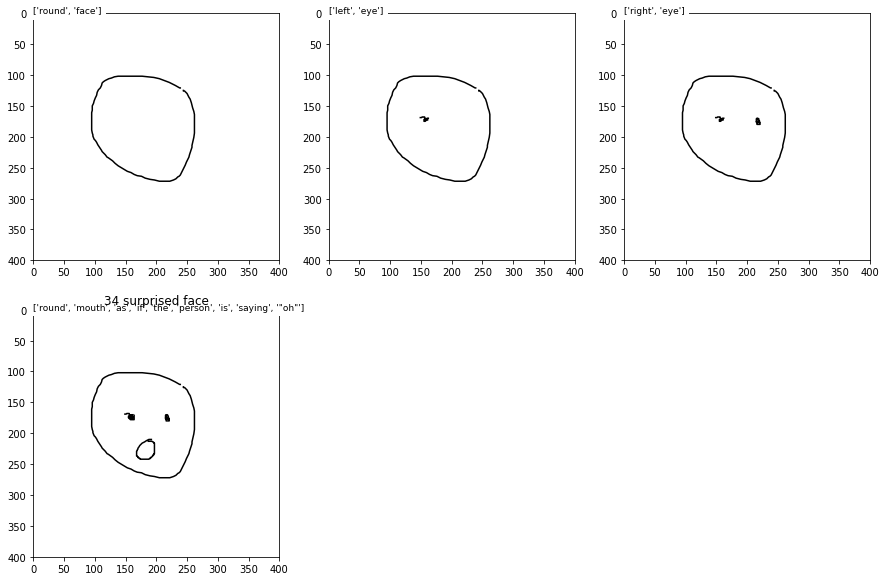

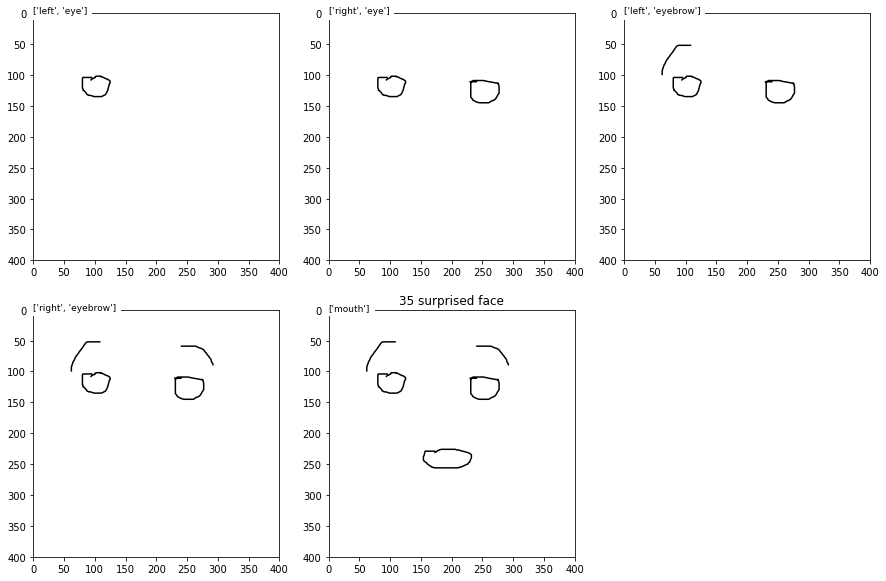

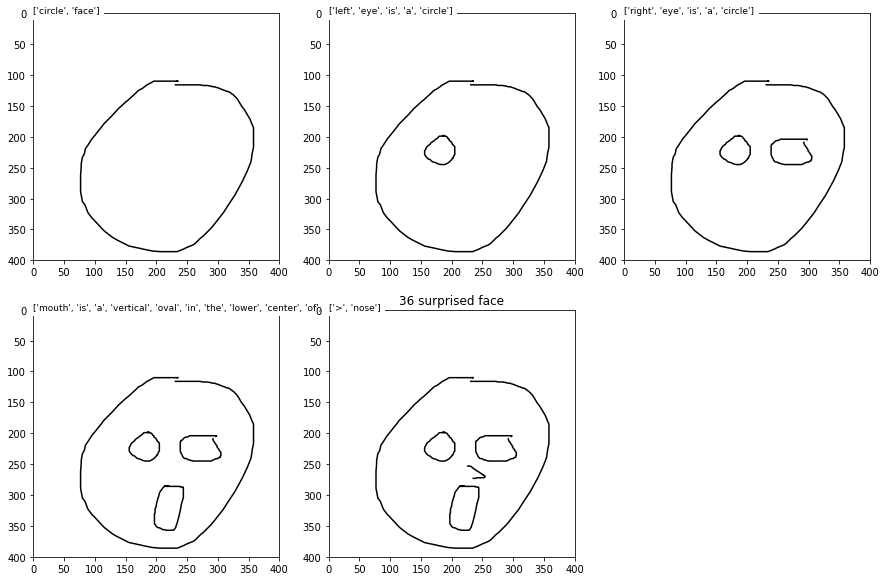

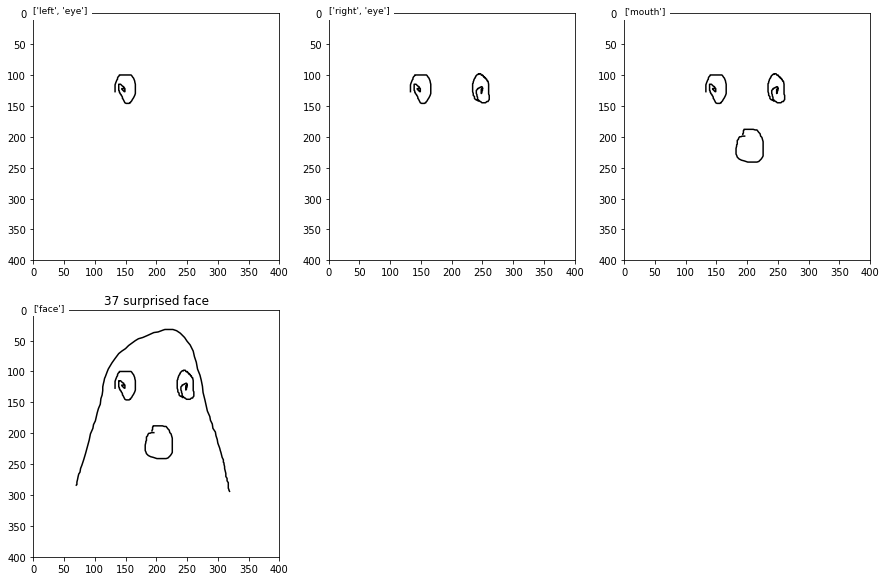

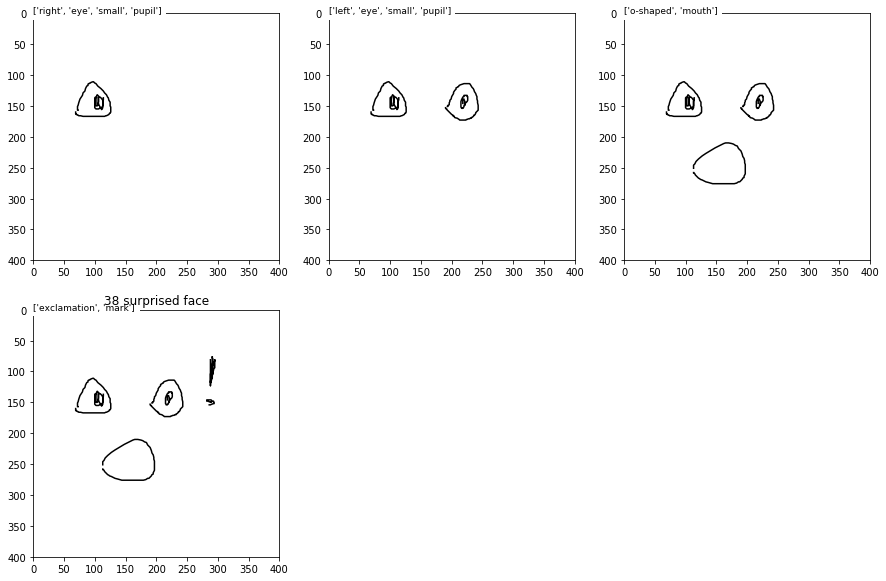

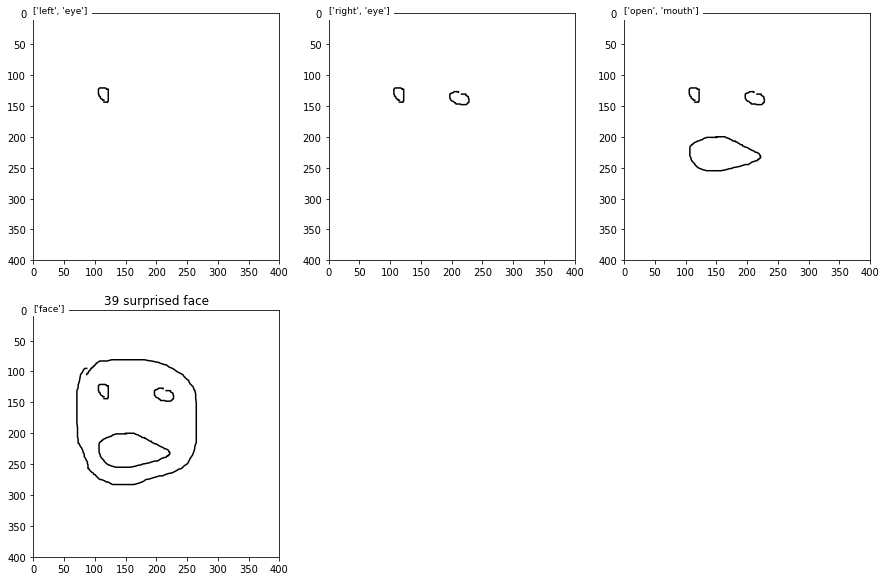

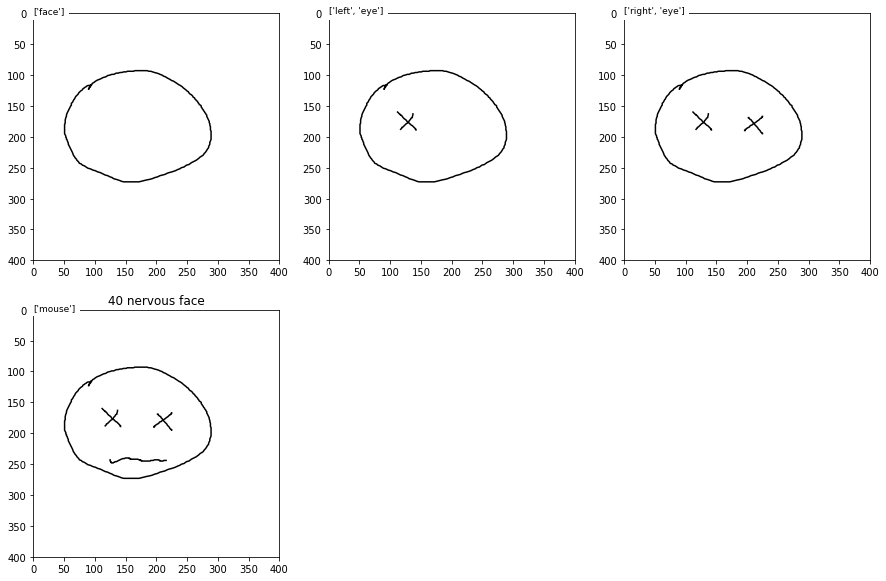

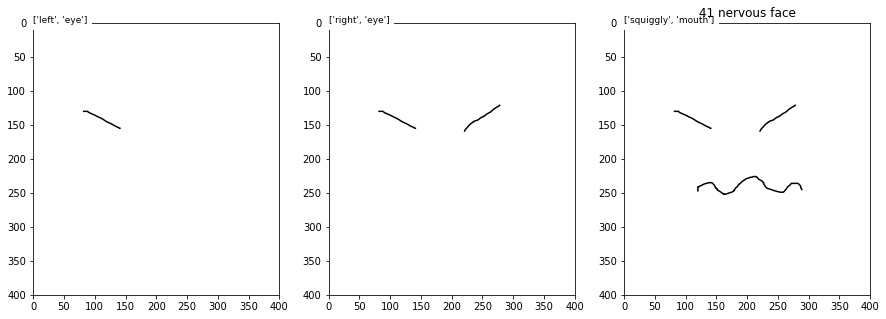

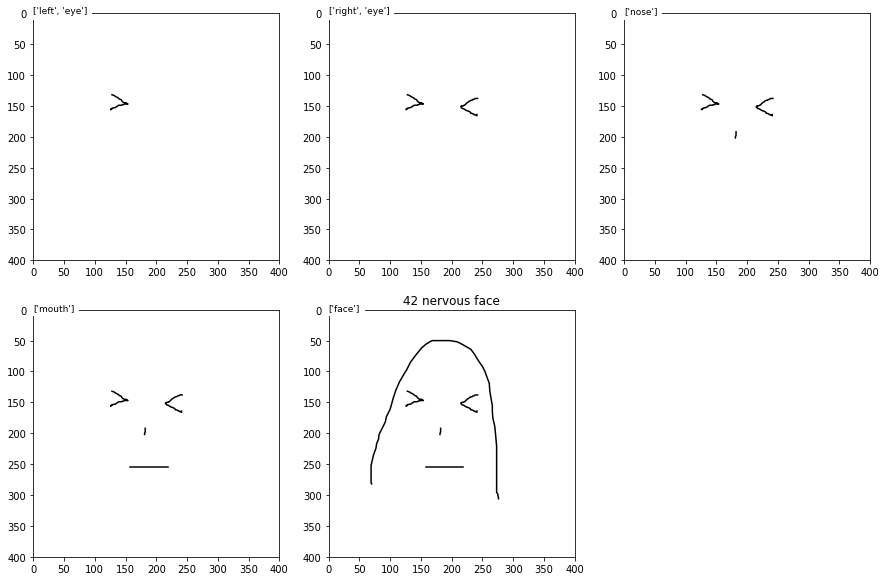

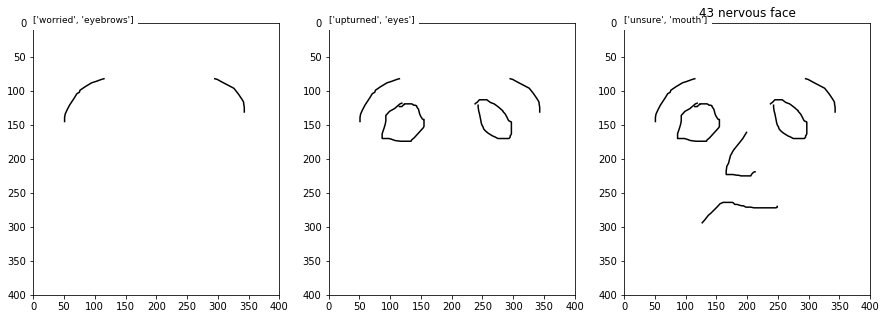

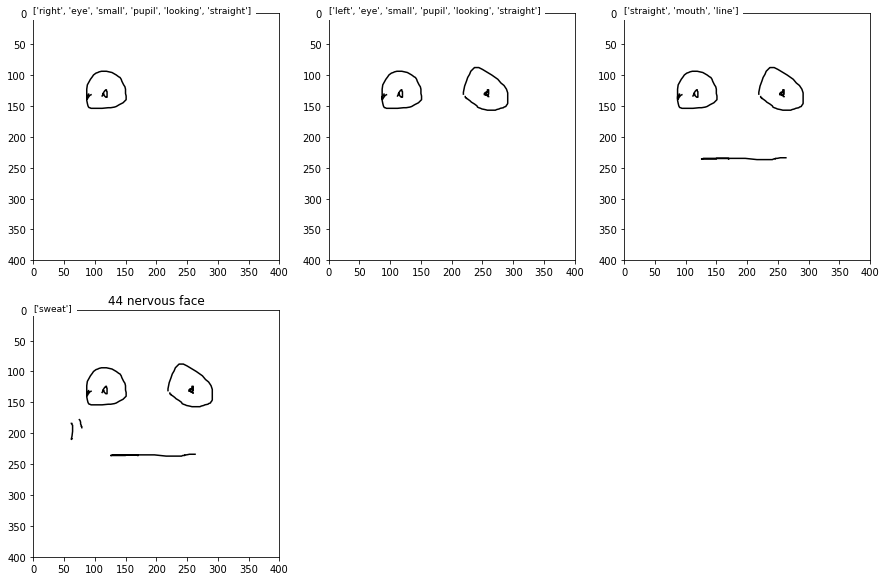

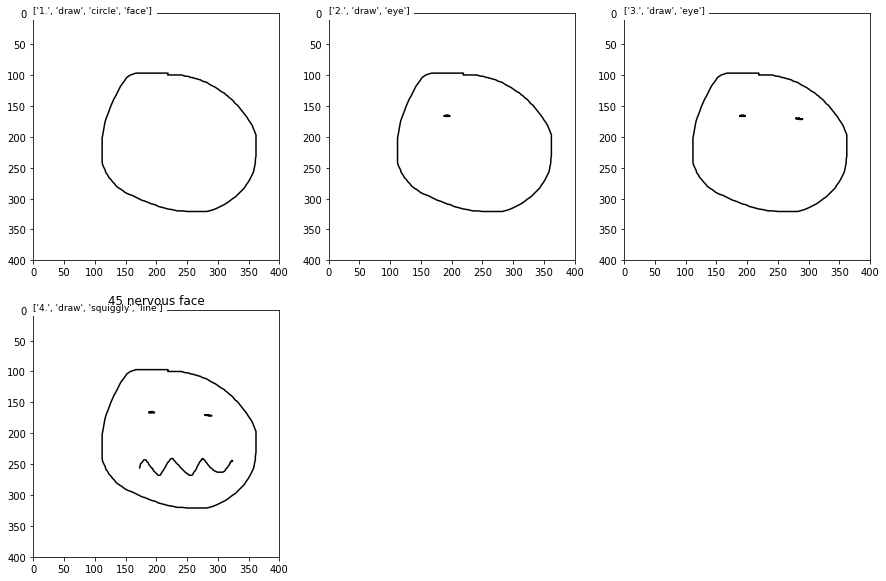

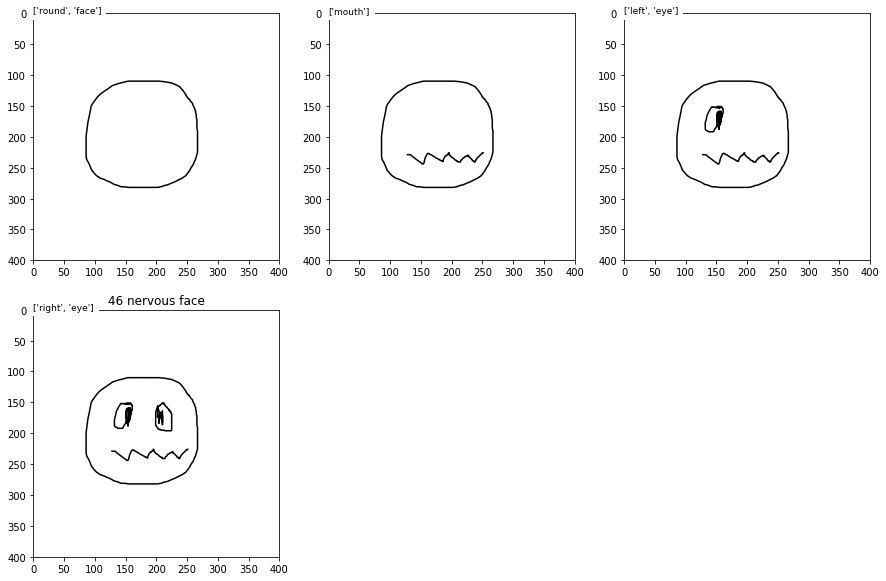

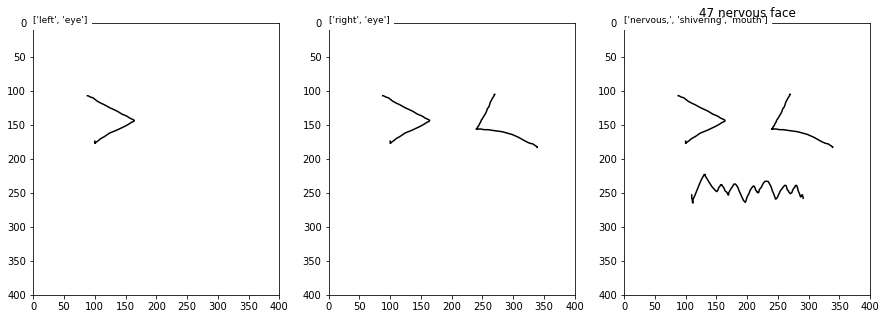

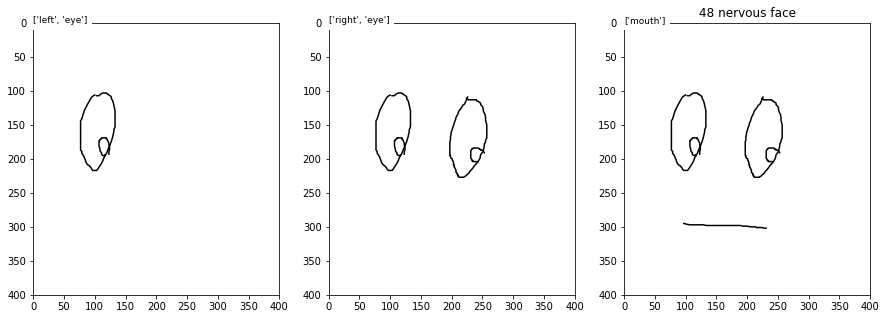

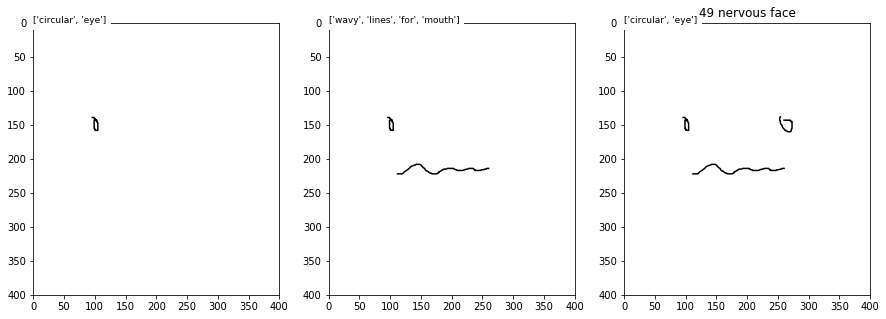

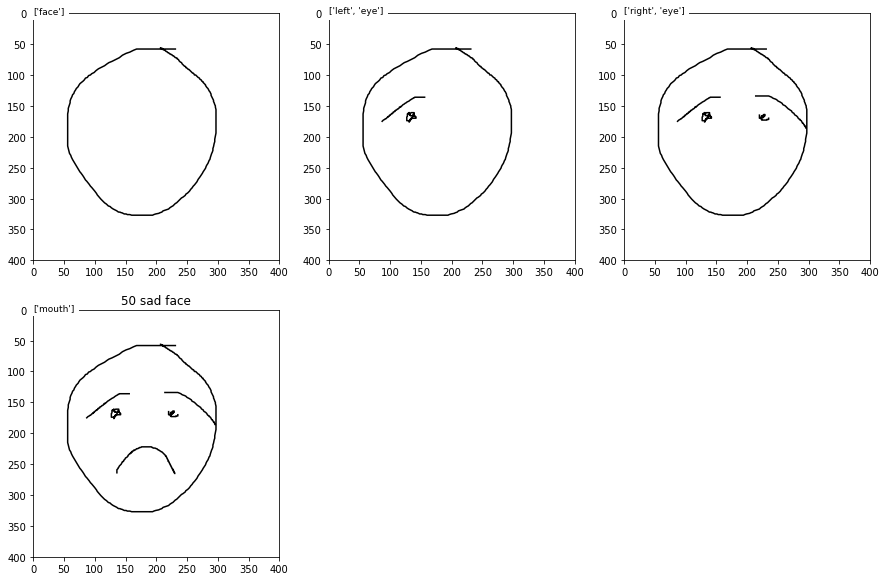

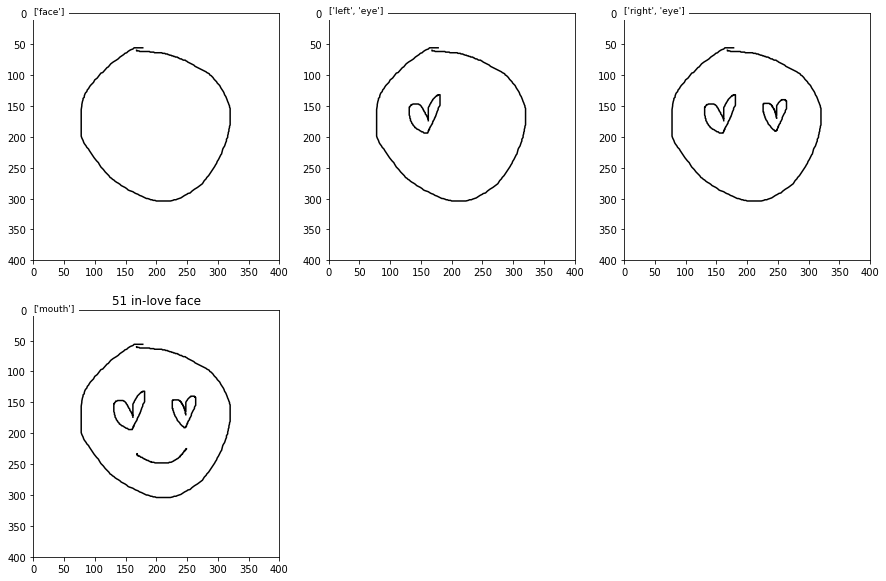

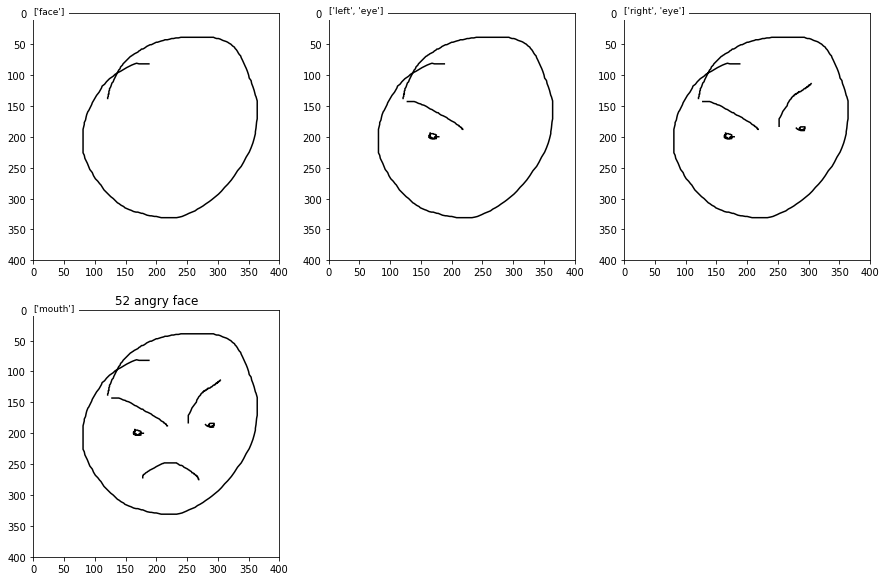

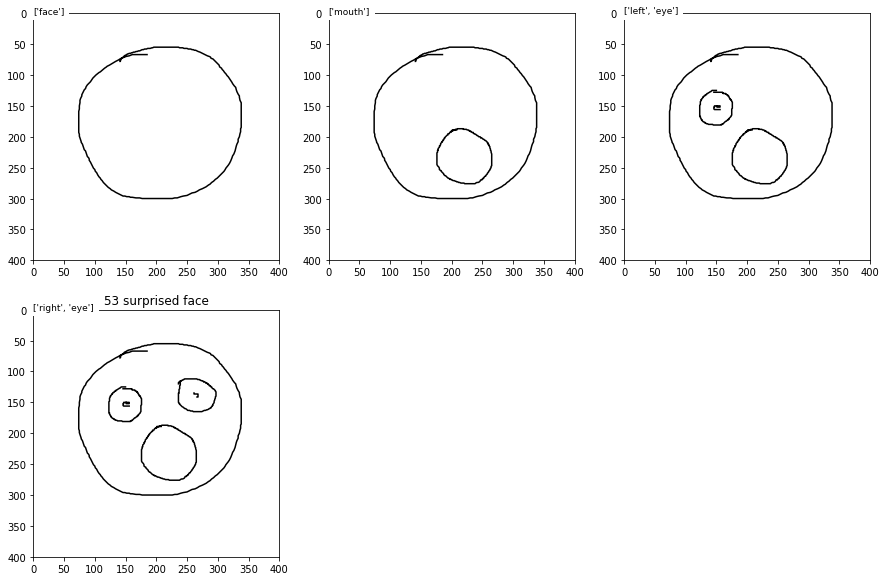

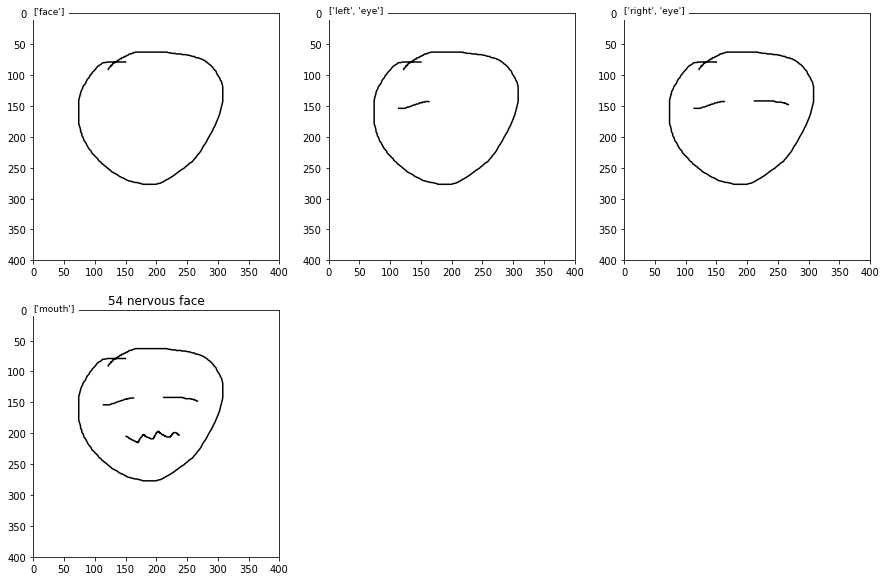

In [13]:
for i in range(len(face_obj.data)):
    face_obj.draw(i)

In [ ]:
# Drawing with problems:
'''
(A2ALG12AYP0P77) 7, 18, 23, 38, 44: left eye on right
'''
'''
12: left eye, the other half of left eye
50: left eye contains left eye and left eyebrow
'''

In [88]:
def fit_gaussian(X):
    X_mean = np.mean(X, axis=0)
    X_cov = np.cov(X, rowvar=0)
    X_diag = np.diag(X_cov)
    X_stddev = np.sqrt(X_diag)
    
    mvn = tfd.MultivariateNormalDiag(loc=X_mean, scale_diag=X_stddev)
    mvn_mean = mvn.mean().numpy()
    mvn_cov = mvn.covariance().numpy()
    mvn_stddev = mvn.stddev().numpy()
    
    return mvn_mean, mvn_cov

from sklearn import mixture
from matplotlib.patches import Ellipse

def draw_ellipse(X, position, covariance, ax, fc=None, **kwargs):
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    fc = fc if fc is not None else np.random.rand(3)
    for nsig in range(1, 4):
        e = Ellipse(position, nsig * width, nsig * height, angle, **kwargs)
        # ax.add_patch()
        ax.add_artist(e)
        e.set_facecolor(fc)
    
    ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, c=fc.reshape(1,-1))
    
    ax.set_xlim(0, 400)
    ax.set_ylim(400, 0)
    return fc

In [89]:
def check_text(text, keywords, excludes):
    text = text.lower()
    flag = False
    for k in keywords:
        if k in text:
            flag = True
    
    for k in excludes:
        if k in text:
            flag=False
    
    return flag

def num_criteria_satisfied(face_obj, keywords, excludes):
    
    all_text = face_obj.all_texts()
    all_drawing = face_obj.all_drawings()
    
    assert len(all_text) == len(all_drawing)
    
    satisfied_count = np.zeros((len(all_text),))
    
    satisfied_drawing = []
    dummy = 0
    for i,(texti, drawingi) in enumerate(zip(all_text, all_drawing)):
        acc = 0
        acc_bad = 0
        drawingi_satisfied = []
        for j,(textij, drawingij) in enumerate(zip(texti, drawingi)):
            flag = True
            for k in keywords:
                one_in = False
                for ki in k:
                    if ki in textij:
                        one_in = True
                
                if not one_in:
                    flag = False
            
            for k in excludes:
                if k in textij:
                    flag = False
            
            if not flag:
                continue
            
            print(textij, i)
            dummy += 1
            
            satisfied_count[i] = 1
            drawingi_satisfied.append(drawingij)
            
            # print(np.mean(drawingij, axis=0))
        
        if(len(drawingi_satisfied) > 0):
            satisfied_drawing.append(np.vstack(drawingi_satisfied))
        
    
    
    return satisfied_count, satisfied_drawing

def get_bboxs(drawing):
    bboxs = []
    centers = []
    for drawingi in drawing:         
        bbox = [np.min(drawingi, axis=0).reshape(-1,), np.max(drawingi, axis=0).reshape(-1,)]
        bboxs.append(np.asarray(bbox))
        
        centers.append(np.mean(np.asarray(bbox), axis=0).astype(int))
        
    return np.asarray(bboxs), np.asarray(centers)

def draw_all(arr):
    plt.figure(figsize=(10,10))
    plt.xlim(0,400)
    plt.ylim(400,0)
    for i in range(len(arr)):
        plt.plot(arr[i][:,0], arr[i][:,1])
    plt.show()

In [90]:
def plot_gaussian(obj, keywords, excludes):
    mask, drawing = num_criteria_satisfied(face_obj, keywords, excludes)
    bboxs, centers = get_bboxs(drawing)
    draw_all(drawing)

    mean, cov = fit_gaussian(centers)
    fig, ax = plt.subplots(figsize=(10,10)) #subplot_kw={'aspect': 'equal'}
    fc = draw_ellipse(centers, mean, cov, ax=ax, alpha=0.4)
    plt.show()
    return bboxs, centers, mean, cov, fc

['left', 'eye'] 0
['left', 'eye', 'that', 'is', 'a', 'upward', 'opening', 'semicircle'] 1
['sad', 'left', 'eye'] 2
['left', 'eye'] 5
['left', 'eye'] 6
['left', 'eye', 'looking', 'down'] 7
['left', 'eye'] 9
['left', 'eye'] 11
['half', 'of', 'left', 'heart', 'eye'] 12
['the', 'other', 'half', 'of', 'left', 'heart', 'eye'] 12
['left', 'eye'] 13
['left', 'eye'] 14
['heart', 'left', 'eye'] 15
['left', 'eye'] 17
['narrow,', 'smiley', 'left', 'eye'] 18
['left', 'eye'] 19
['left', 'eye'] 20
['left', 'eye'] 21
['left', 'eye'] 22
['left', 'eye'] 25
['left', 'eye'] 27
['left', 'eye'] 28
['left', 'eye'] 29
['left', 'eye'] 30
['left', 'eye'] 31
['left', 'eye'] 32
['left', 'eye'] 34
['left', 'eye'] 35
['left', 'eye', 'is', 'a', 'circle'] 36
['left', 'eye'] 37
['left', 'eye', 'small', 'pupil'] 38
['left', 'eye'] 39
['left', 'eye'] 40
['left', 'eye'] 41
['left', 'eye'] 42
['left', 'eye', 'small', 'pupil', 'looking', 'straight'] 44
['left', 'eye'] 46
['left', 'eye'] 47
['left', 'eye'] 48
['left', 'eye'

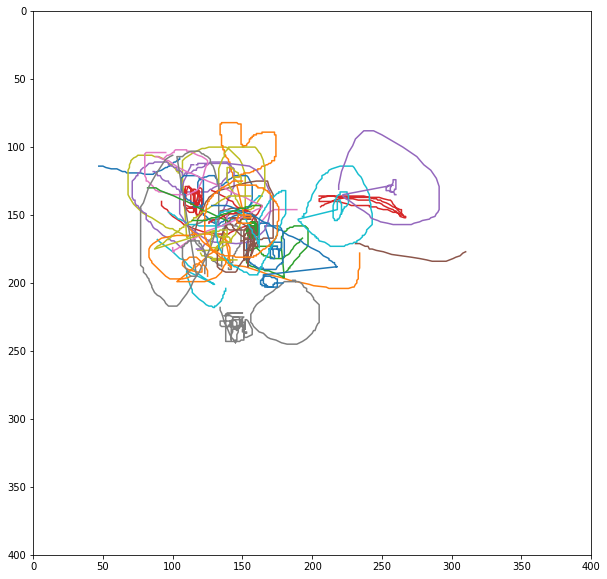

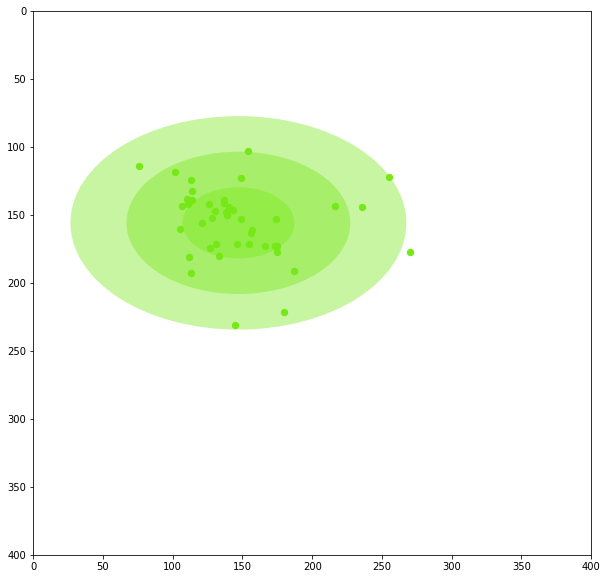

In [91]:
leftb, leftc, leftm, leftv, color1 = plot_gaussian(face_obj, [["left"], ["eye"]], ["eyes", "brow", "eyebrow"])

['right', 'eye'] 0
['right', 'eye', 'that', 'is', 'an', 'upward', 'opening', 'semicircle'] 1
['sad', 'right', 'eye'] 2
['right', 'eye'] 5
['right', 'eye'] 6
['right', 'eye', 'looking', 'down'] 7
['right', 'eye'] 9
['right', 'eye'] 11
['half', 'of', 'right', 'heart', 'eye'] 12
['the', 'other', 'half', 'of', 'right', 'heart', 'eye'] 12
['right', 'eye'] 13
['right', 'eye'] 14
['heart', 'right', 'eye'] 15
['right', 'eye'] 17
['narrow,', 'smiley', 'right', 'eye'] 18
['right', 'eye'] 19
['right', 'eye'] 20
['right', 'eye'] 21
['right', 'eye'] 22
['right', 'eye'] 25
['right', 'eye'] 27
['right', 'eye'] 28
['right', 'eye'] 29
['right', 'eye'] 30
['right', 'eye'] 31
['right', 'eye'] 32
['right', 'eye'] 34
['right', 'eye'] 35
['right', 'eye', 'is', 'a', 'circle'] 36
['right', 'eye'] 37
['right', 'eye', 'small', 'pupil'] 38
['right', 'eye'] 39
['right', 'eye'] 40
['right', 'eye'] 41
['right', 'eye'] 42
['right', 'eye', 'small', 'pupil', 'looking', 'straight'] 44
['right', 'eye'] 46
['right', 'eye

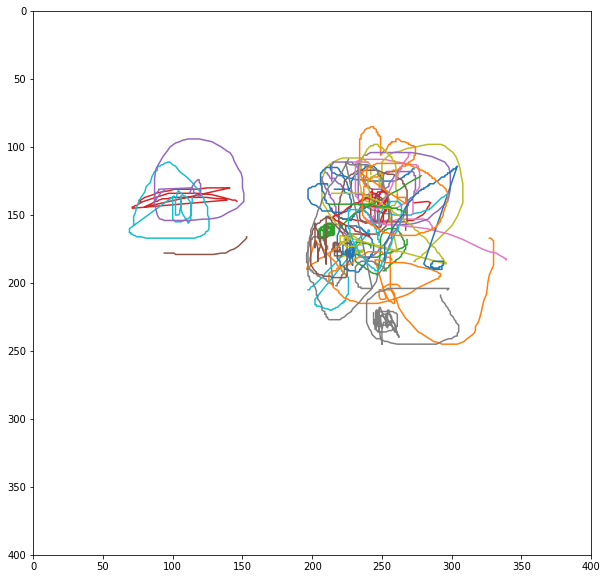

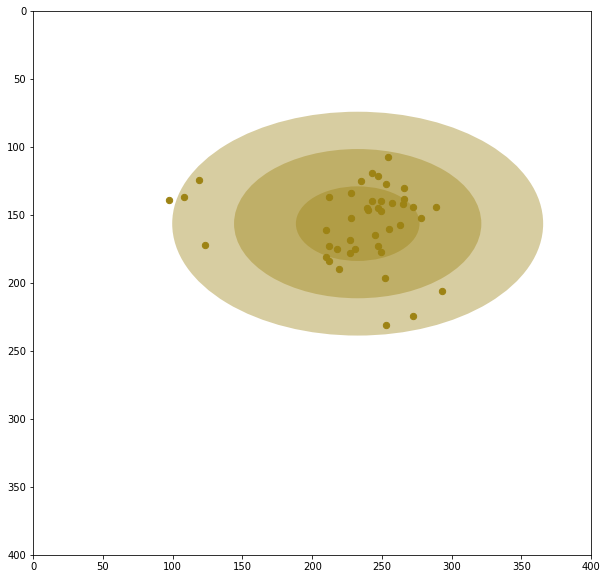

In [99]:
rightb, rightc, rightm, rightv,color2 = plot_gaussian(face_obj, [["right"], ["eye"]], ["eyes", "brow", "eyebrow"])

['frowning', 'mouth'] 0
['frowny', 'mouth', 'that', 'is', 'an', 'downward', 'opening', 'semicircle'] 1
['sad', 'mouth'] 2
['sad', 'mouth'] 3
['sad', 'mouth'] 5
['frowning', 'mouth'] 6
['mouth', 'frown'] 7
['mouth'] 8
['mouth'] 9
['open', 'mouth'] 10
['smiley', 'mouth'] 12
['wide', 'smiley', 'mouth'] 12
['smiling', 'mouth'] 13
['mouth'] 14
['mouth'] 15
['smiley', 'mouth'] 17
['mouth'] 19
['mouth'] 20
['frowning', 'mouth'] 21
['a', 'mouth', 'which', 'opens', 'widely', 'like', "it's", 'shouting', 'out', 'words'] 22
['mouth', 'shut', 'tight'] 23
['mouth', 'and', 'eyebrows'] 24
['mouth'] 25
['mouth'] 26
['angry', 'mouth'] 27
['angry', 'mouth'] 28
['mouth'] 29
['a', 'mouth', 'that', 'opens', 'widely'] 31
['surprised', 'mouth'] 32
['round', 'mouth', 'as', 'if', 'the', 'person', 'is', 'saying', '"oh"'] 34
['mouth'] 35
['mouth', 'is', 'a', 'vertical', 'oval', 'in', 'the', 'lower', 'center', 'of', 'the', 'face'] 36
['mouth'] 37
['o-shaped', 'mouth'] 38
['open', 'mouth'] 39
['squiggly', 'mouth'] 

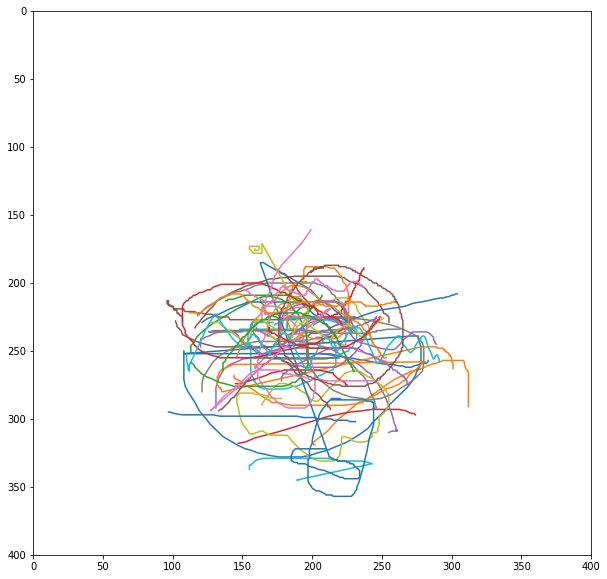

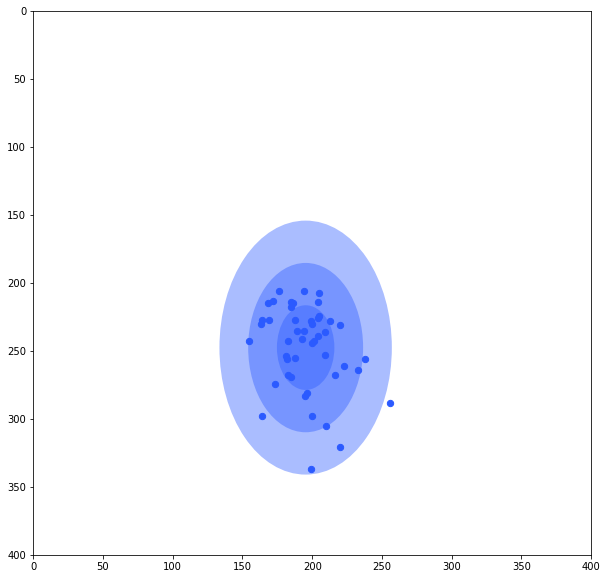

In [93]:
mouthb, mouthc, mouthm, mouthv, color3 = plot_gaussian(face_obj, [["mouth"]], [])

['left', 'brow'] 20
['left', 'eyebrow'] 21
['left', 'eyebrow', 'which', 'is', 'thick', 'and', 'tilting', 'upward'] 22
['frowned', 'left', 'brow'] 23
['left', 'eyebrow'] 25
['left', 'eyebrow'] 27
['left', 'eyebrow'] 28
['left', 'eyebrow'] 29
['left', 'eyebrow'] 35


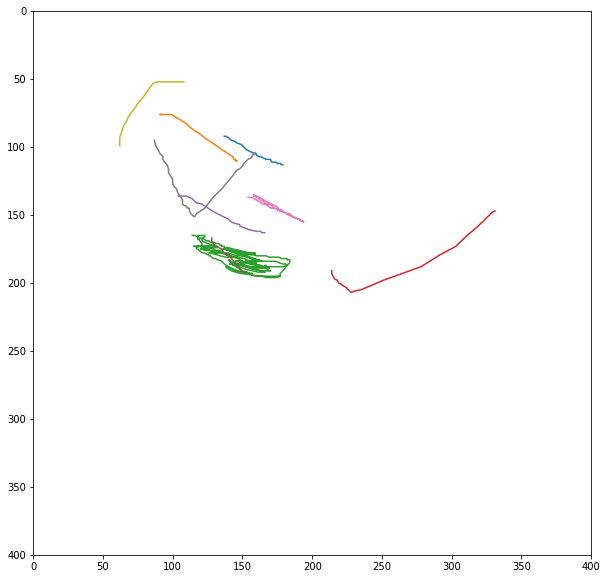

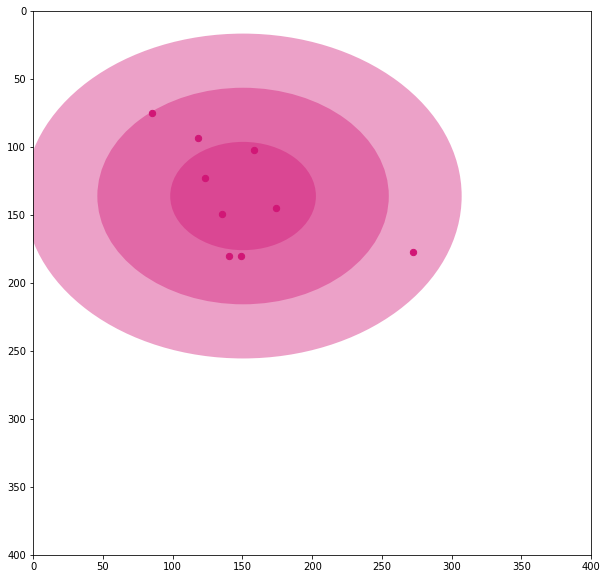

In [94]:
leftbrowb, leftbrowc, leftbrowm, leftbrowv, color4 = plot_gaussian(face_obj, 
                                               [["left"], ["eyebrow", "brow"]], ["eye", "eyes", "eyebrows"])

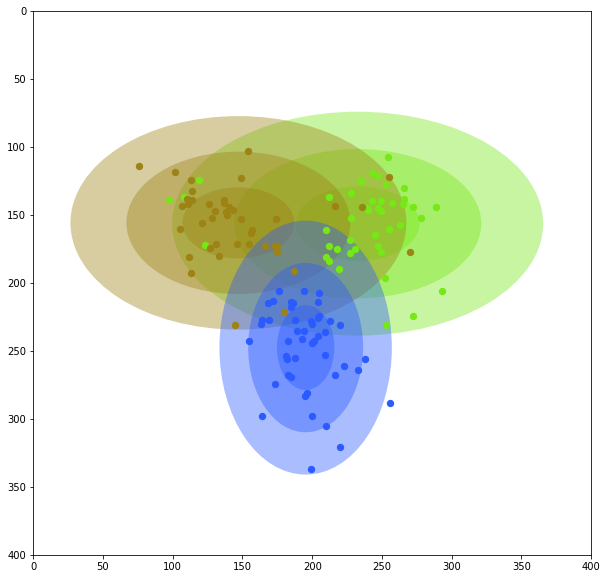

In [101]:
fig, ax = plt.subplots(figsize=(10,10)) #subplot_kw={'aspect': 'equal'}
draw_ellipse(rightc, rightm, rightv, ax=ax, fc = color1, alpha=0.4)
draw_ellipse(leftc, leftm, leftv, ax=ax, fc = color2, alpha=0.4)
draw_ellipse(mouthc, mouthm, mouthv, ax=ax, fc = color3, alpha=0.4)
# draw_ellipse(leftbrowc, leftbrowm, leftbrowv,fc = color4,  ax=ax, alpha=0.4)
plt.show()

In [ ]:
################################################################ Text Analysis


In [37]:
################################################################ Experiment 
# Gaussian distribution of "eyes"

In [102]:
def invert_indices(n_features, indices):
    inv = np.ones(n_features, dtype=np.bool)
    inv[indices] = False
    inv, = np.where(inv)
    return inv

In [192]:
def cond_cov(x,y):
    xy = np.hstack([x, y]).T    
    cov_mat = np.cov(xy)
    return cov_mat

def cond_gaussian(x1,x2, mu1, mu2, sigma1, sigma2):
    sigma_12 = cond_cov(x1,x2)[:2,2:]
    sigma_21 = cond_cov(x2,x1)[:2,2:]
    sigma_11 = sigma1
    sigma_22 = sigma2
    
    cond_mu = (sigma_12 @ np.linalg.inv(sigma_11) @ (x2 - mu2).T).T
    cond_mu = mu1.reshape((1,2)) + cond_mu
    cond_cov_mat = sigma_11 - sigma_12 @ np.linalg.inv(sigma_22) @ sigma_21
    
    return cond_mu, cond_cov_mat

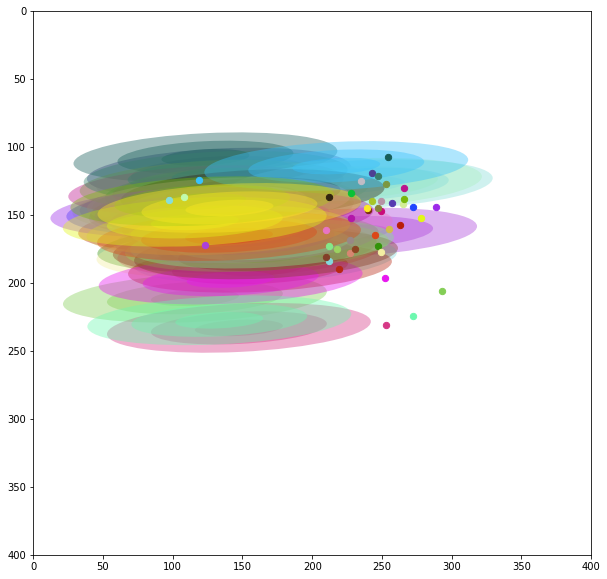

In [199]:
cond_mu, cond_cov_mat = cond_gaussian(leftc, rightc, leftm, rightm, leftv, rightv)

fig, ax = plt.subplots(figsize=(10,10)) 
for i in range(len(rightc)):
    fc = draw_ellipse(rightc[i].reshape((1,2)), cond_mu[i], cond_cov_mat, ax=ax, alpha=0.4)
plt.show()

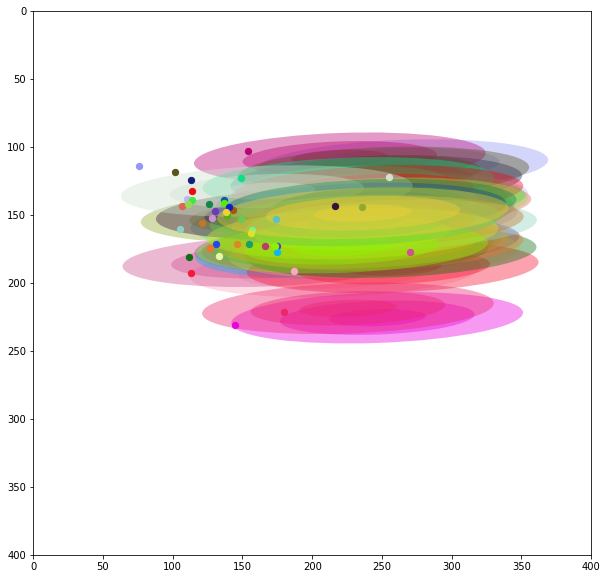

In [198]:
cond_mu, cond_cov_mat = cond_gaussian(rightc, leftc, rightm, leftm, rightv, leftv)

fig, ax = plt.subplots(figsize=(10,10)) 
for i in range(len(leftc)):
    fc = draw_ellipse(leftc[i].reshape((1,2)), cond_mu[i], cond_cov_mat, ax=ax, alpha=0.4)
plt.show()

In [10]:


def get_bbox_center(df, row_idx, keywords = ['eye'], excludes = ['eyebrow', 'eyes']):
    df_row = df.iloc[row_idx]
    components_accumatlor = []
    for k,v in df_row.items():        
        if not k.startswith("Answer.canvasJsonOneStepName"):
            continue

        if v is np.nan:
            continue        

        try:
            part_xy, text, action_id = get_xy(v)
        except:
            print("Problem: ", row_idx)
            continue
        
        if check_text(text, keywords, excludes):
            if(len(part_xy) > 1):
                part_xy = np.vstack(part_xy)
                part_xy = np.expand_dims(part_xy, axis=0)
            else:
                part_xy = np.asarray(part_xy)
            
            bbox = [np.min(part_xy, axis=1).reshape(-1,), np.max(part_xy, axis=1).reshape(-1,)]
            components_accumatlor.append(np.mean(np.asarray(bbox), axis=0).astype(int))
    
    
    return np.asarray(components_accumatlor)




In [11]:
def process_eye(df):
    eyes = []
    
    for i in range(len(df)):
        
        eye_centers = get_bbox_center(
            df,
            i,
            keywords=["eye"], 
            excludes=["eyebrow", "eyeball", "eye ball", "eyes"],
        )
        
        if(len(eye_centers) < 1):
            continue
        
        left_eye = np.min(eye_centers, axis=0)
        right_eye = np.max(eye_centers, axis=0)
        normalized_eye = right_eye - left_eye
                
        eyes.append(normalized_eye)
    return eyes

In [12]:
right_eye = process_eye(df)

[get_xy] mouth
Problem:  50
[get_xy] mouth
Problem:  51
[get_xy] mouth
Problem:  52
[get_xy] right eye
Problem:  53
[get_xy] mouth
Problem:  54


In [13]:
X = np.asarray(right_eye)

In [14]:
X_mean = np.mean(X, axis=0)
X_cov = np.cov(X, rowvar=0)
X_diag = np.diag(X_cov)
X_stddev = np.sqrt(X_diag)

In [15]:
mvn = tfd.MultivariateNormalTriL(
 loc=X_mean,
 scale_tril=tf.linalg.cholesky(X_cov))

In [16]:
mvn = tfd.MultivariateNormalDiag(
 loc=X_mean,
 scale_diag=X_stddev)
mvn_mean = mvn.mean().numpy()
mvn_cov = mvn.covariance().numpy()
mvn_stddev = mvn.stddev().numpy()


In [25]:
mvn_mean, mvn_cov, mvn_stddev

(array([111.85416667,   5.08333333]), array([[937.10593972,   0.        ],
        [  0.        ,  20.33333333]]), array([30.61218613,  4.50924975]))

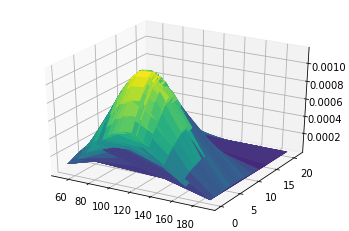

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy

x1, x2 = np.meshgrid(X[:,0], X[:,1])
data = np.stack((x1.flatten(), x2.flatten()), axis=1)
prob = mvn.prob(data).numpy()
ax = plt.axes(projection='3d')
ax.plot_surface(x1, x2, prob.reshape(x1.shape), cmap='viridis')
plt.show()

(2304,)

[[1. 0.]
 [0. 1.]]
[937.10593972  20.33333333]
[[1. 0.]
 [0. 1.]]
61.22437226191256 9.018499505645789 0.0


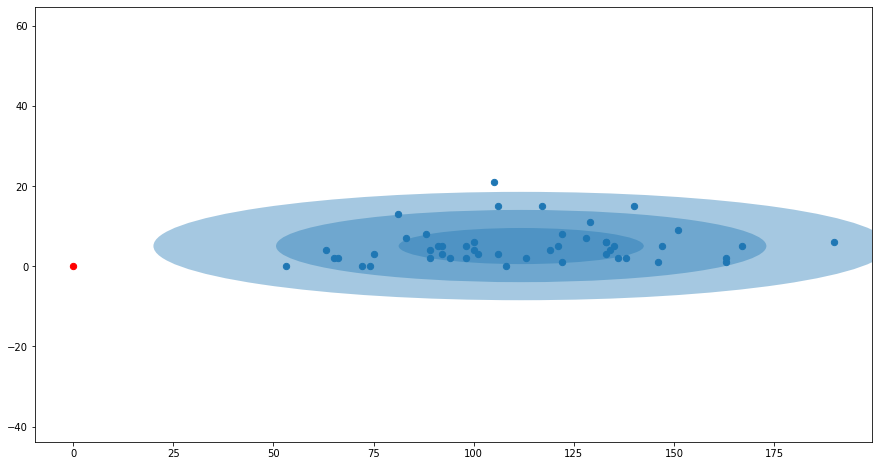

In [54]:


    


plot_g(X)

In [ ]:



        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


In [ ]:
def check_text(text, keywords, excludes):
    text = text.lower()
    flag = False
    for k in keywords:
        if k in text:
            flag = True
    
    for k in excludes:
        if k in text:
            flag=False
    
    return flag

def num_criteria_satisfied(face_obj, keywords, excludes):
    
    all_text = face_obj.all_texts()
    all_drawing = face_obj.all_drawings()
    
    assert len(all_text) == len(all_drawing)
    
    satisfied_count = np.zeros((len(all_text),))
    
    satisfied_drawing = []
    dummy = 0
    for i,(texti, drawingi) in enumerate(zip(all_text, all_drawing)):
        acc = 0
        acc_bad = 0
        drawingi_satisfied = []
        for j,(textij, drawingij) in enumerate(zip(texti, drawingi)):
            flag = True
            for k in keywords:
                if k not in textij:
                    flag = False
            
            for k in excludes:
                if k in textij:
                    flag = False
            
            if not flag:
                continue
            
            # print(textij, i, drawingij.shape)
            dummy += 1
            
            satisfied_count[i] = 1
            drawingi_satisfied.append(drawingij)
        
        if(len(drawingi_satisfied) > 0):
            satisfied_drawing.append(np.vstack(drawingi_satisfied))
        
    
    
    return satisfied_count, satisfied_drawing